In [54]:
import pandas as pd
import numpy as np
from datetime import timedelta
import datetime
from pytz import timezone, utc
from timezonefinder import TimezoneFinder
import geopy.distance
import matplotlib.pyplot as plt
import math
import geopandas as gpd
import pyproj
from geojson import Point, LineString, Feature, FeatureCollection, dump

plt.rcParams['font.size'] = '20'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 999)


# AIR TRAVEL (2015-)

In [55]:
ROOT_DIR = '/Users/alexanderguo/Documents/github/frontend/flightlog/'
df = pd.read_csv(ROOT_DIR + 'flightlog.csv')
airports = pd.read_csv(ROOT_DIR + 'airports.csv')

tf = TimezoneFinder()

def get_offset(t, lat, lng):
    """
    returns a location's time zone offset from UTC in hours.
    """
    tz_target = timezone(tf.certain_timezone_at(lng=lng, lat=lat))
    today_target = tz_target.localize(t)
    today_utc = utc.localize(t)
    return (today_utc - today_target).total_seconds() / 3600

# Main processing

In [56]:
# Merge with airports CSV
df = df.merge(airports[['Name', 'City', 'Country', 'IATA', 'Lat', 'Long']], 
              left_on='Dep Airport', right_on='IATA', how='left')
df = df.drop(columns='IATA').rename(columns={'Name': 'Dep Name', 
                                             'Lat': 'Dep Lat', 
                                             'Long': 'Dep Long', 
                                             'City': 'Dep City', 
                                             'Country': 'Dep Country'})
df = df.merge(airports[['Name', 'City', 'Country', 'IATA', 'Lat', 'Long']], 
              left_on='Arr Airport', right_on='IATA', how='left')
df = df.drop(columns='IATA').rename(columns={'Name': 'Arr Name', 
                                             'Lat': 'Arr Lat', 
                                             'Long': 'Arr Long', 
                                             'City': 'Arr City', 
                                             'Country': 'Arr Country'})

In [57]:
# Date cleaning


DATETIME_COLS = ['Scheduled Dep Time (Local)', 
                 'Scheduled Arr Time (Local)', 
                 'Actual Dep Time (Local)', 
                 'Actual Arr Time (Local)']
important_cols = ['Date', 
                  'Scheduled Dep Time (Local)', 
                  'Scheduled Arr Time (Local)', 
                  'Actual Duration', 
                  'Airline', 
                  'Flight', 
                  'Dep Airport', 
                  'Arr Airport', 
                  'Distance', 
                  'Dep Delay (min)', 
                  'Dep Delay (min)', 
                  'Class', 
                  'Aircraft', 
                  'Registration']



df['Date'] = pd.to_datetime(df['Date'])

# Convert times to datetime object with offset from (+1) if needed.
# Note: minus not supported.
for col in DATETIME_COLS:
    for i, r in df.iterrows():
        time = str(r[col])
        if not pd.isna(r[col]):
            datetime_str = r['Date'].strftime('%Y-%m-%d') + ' ' + time.split('+')[0]
            days_offset = 0 if '+' not in time else int(time.split('+')[1])
            df.loc[i, col] = pd.to_datetime(datetime_str) + pd.Timedelta(days=days_offset)
    df[col] = pd.to_datetime(df[col])
# Set actual for future flights.
df['Actual Dep Time (Local)'] = df['Actual Dep Time (Local)'].fillna(df['Scheduled Dep Time (Local)'])
df['Actual Arr Time (Local)'] = df['Actual Arr Time (Local)'].fillna(df['Scheduled Arr Time (Local)'])


# Get departure and arrival time zones.
df['Dep Timezone'] = df[['Dep Lat', 'Dep Long']].apply(
    lambda r: timezone(tf.certain_timezone_at(lng=r['Dep Long'], lat=r['Dep Lat'])), axis=1)
df['Arr Timezone'] = df[['Arr Lat', 'Arr Long']].apply(
    lambda r: timezone(tf.certain_timezone_at(lng=r['Arr Long'], lat=r['Arr Lat'])), axis=1)

# Calculate times in UTC.
# Known error for Jordan (appears time zone is equivalent to Cairo tome)
for col in DATETIME_COLS:
    utc_col = col.split('(')[0] + '(UTC)'
    dep_or_arr = 'Dep' if 'Dep' in col else 'Arr'
    for i, r in df.iterrows():
        hours_offset = get_offset(datetime.datetime.strptime(
            r[col].strftime("%m/%d/%Y, %H:%M:%S"), "%m/%d/%Y, %H:%M:%S"), 
                                  r[dep_or_arr + ' Lat'], r[dep_or_arr + ' Long']);
        df.loc[i, utc_col] = r[col] - timedelta(hours=hours_offset)
    

# Calculate actual durations
for col in ['Scheduled Duration', 'Actual Duration']:
    df[col] = df[col.split(' ')[0] + ' Arr Time (UTC)'] - df[col.split(' ')[0] + ' Dep Time (UTC)']
    df[col + ' (min)'] = df[col].dt.total_seconds() / 60
    
# Do duration checking.
for i, r in df.iterrows():
    if r['Actual Duration (min)'] < 0 or r['Actual Duration (min)'] > 1440 or r['Scheduled Duration (min)'] < 0 or r['Scheduled Duration (min)'] > 1440:
        print('Please check this row, the duration is wrong', r)
        raise ValueError('Duration error')

/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3542269883.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [58]:
# Add some extra columns

df['Distance'] = df.apply(lambda row: geopy.distance.distance((row['Dep Lat'], row['Dep Long']), (row['Arr Lat'], row['Arr Long'])).miles, axis=1).round().astype(int)
df['Dep Delay'] = df['Actual Dep Time (UTC)'] - df['Scheduled Dep Time (UTC)']
df['Arr Delay'] = df['Actual Arr Time (UTC)'] - df['Scheduled Arr Time (UTC)']
for i, r in df.iterrows():
    df.loc[i, 'Dep Delay (min)'] = r['Dep Delay'].seconds//60 if r['Dep Delay'].days >= 0 else r['Dep Delay'].seconds//60-1440
    df.loc[i, 'Arr Delay (min)'] = r['Arr Delay'].seconds//60 if r['Arr Delay'].days >= 0 else r['Arr Delay'].seconds//60-1440
    df.loc[i, 'Domestic/International'] = 'International' if r['Dep Country'] != r['Arr Country'] else 'Domestic'
    if i > 0:
        df.loc[i, 'Last flight arrival (UTC)'] = df.loc[i-1, 'Actual Arr Time (UTC)']
        df.loc[i, 'Time since last flight'] = r['Actual Dep Time (UTC)'] - df.loc[i, 'Last flight arrival (UTC)']

df['Minutes Made Up'] = df['Dep Delay (min)'] - df['Arr Delay (min)']

current_datetime_utc = pd.Timestamp.utcnow().tz_convert('UTC')
past_df = df[df['Scheduled Arr Time (UTC)'].dt.tz_localize('UTC') <= current_datetime_utc]
future_df = df[df['Scheduled Arr Time (UTC)'].dt.tz_localize('UTC') > current_datetime_utc]
past_df.head()

Date Scheduled Dep Time (Local) Scheduled Arr Time (Local)  \
0 2015-01-03        2015-01-03 13:45:00        2015-01-03 14:10:00   
1 2015-03-08        2015-03-08 08:34:00        2015-03-08 10:01:00   
2 2015-03-08        2015-03-08 12:55:00        2015-03-09 15:00:00   
3 2015-03-19        2015-03-19 17:00:00        2015-03-19 18:45:00   
4 2015-03-19        2015-03-19 20:32:00        2015-03-19 21:46:00   

  Actual Dep Time (Local) Actual Arr Time (Local) Airline  Flight Dep Airport  \
0     2015-01-03 13:55:00     2015-01-03 14:29:00  Hainan   HU481         PEK   
1     2015-03-08 08:52:00     2015-03-08 09:42:00  United  UA1711         BOS   
2     2015-03-08 13:40:00     2015-03-09 15:10:00  United    UA89         EWR   
3     2015-03-19 17:24:00     2015-03-19 18:15:00  United    UA88         PEK   
4     2015-03-19 21:21:00     2015-03-19 22:03:00  United  UA1409         EWR   

  Arr Airport           Class Aircraft Registration  Arr Connect  Unnamed: 13  \
0         BOS         Economy      NaN          NaN          NaN          NaN   
1         EWR  Recliner First     B738       N54241          1.0          NaN   
2         PEK         Economy     B772       N78005          NaN          NaN   
3         EWR         Economy     B772       N78005          1.0          NaN   
4         BOS         Economy     B734       N87512          NaN          NaN   

                                            Dep Name  Dep City    Dep Country  \
0              Beijing Capital International Airport   Beijing          China   
1  General Edward Lawrence Logan International Ai...    Boston  United States   
2               Newark Liberty International Airport  New York  United States   
3              Beijing Capital International Airport   Beijing          China   
4               Newark Liberty International Airport  New York  United States   

     Dep Lat    Dep Long                                           Arr Name  \
0  40.080101  116.584999  General Edward Lawrence Logan International Ai...   
1  42.364300  -71.005203               Newark Liberty International Airport   
2  40.692501  -74.168701              Beijing Capital International Airport   
3  40.080101  116.584999               Newark Liberty International Airport   
4  40.692501  -74.168701  General Edward Lawrence Logan International Ai...   

   Arr City    Arr Country    Arr Lat    Arr Long      Dep Timezone  \
0    Boston  United States  42.364300  -71.005203       Asia/Manila   
1  New York  United States  40.692501  -74.168701  America/New_York   
2   Beijing          China  40.080101  116.584999  America/New_York   
3  New York  United States  40.692501  -74.168701       Asia/Manila   
4    Boston  United States  42.364300  -71.005203  America/New_York   

       Arr Timezone Scheduled Dep Time (UTC) Scheduled Arr Time (UTC)  \
0  America/New_York      2015-01-03 05:45:00      2015-01-03 19:10:00   
1  America/New_York      2015-03-08 12:34:00      2015-03-08 14:01:00   
2       Asia/Manila      2015-03-08 16:55:00      2015-03-09 07:00:00   
3  America/New_York      2015-03-19 09:00:00      2015-03-19 22:45:00   
4  America/New_York      2015-03-20 00:32:00      2015-03-20 01:46:00   

  Actual Dep Time (UTC) Actual Arr Time (UTC) Scheduled Duration  \
0   2015-01-03 05:55:00   2015-01-03 19:29:00    0 days 13:25:00   
1   2015-03-08 12:52:00   2015-03-08 13:42:00    0 days 01:27:00   
2   2015-03-08 17:40:00   2015-03-09 07:10:00    0 days 14:05:00   
3   2015-03-19 09:24:00   2015-03-19 22:15:00    0 days 13:45:00   
4   2015-03-20 01:21:00   2015-03-20 02:03:00    0 days 01:14:00   

   Scheduled Duration (min) Actual Duration  Actual Duration (min)  Distance  \
0                     805.0 0 days 13:34:00                  814.0      6737   
1                      87.0 0 days 00:50:00                   50.0       201   
2                     845.0 0 days 13:30:00                  810.0      6831   
3                     825.0 0 days 12:51:00             

In [59]:
# Calculate totals

TOTAL_DIST = df['Distance'].sum()
TOTAL_TIME = df['Actual Duration (min)'].sum()
NUM_FLIGHTS = df['Date'].count()
NUM_AIRLINES = df['Airline'].nunique()
NUM_COUNTRIES = len(set(df['Dep Country'].tolist()) | set(df['Arr Country'].tolist()))
NUM_AIRPORTS = len(set(df['Dep Airport'].tolist()) | set(df['Arr Airport'].tolist()))

TOTAL_DIST_PAST = past_df['Distance'].sum()
TOTAL_TIME_PAST = past_df['Actual Duration (min)'].sum()
NUM_FLIGHTS_PAST = past_df['Date'].count()

TOTAL_DIST_FUTURE = future_df['Distance'].sum()
TOTAL_TIME_FUTURE = future_df['Actual Duration (min)'].sum()
NUM_FLIGHTS_FUTURE = future_df['Date'].count()

sorted_by_flight_interval = df.sort_values('Time since last flight', ascending=False).reset_index()
LONGEST_INTERVAL = str(sorted_by_flight_interval.loc[0, 'Time since last flight'])
LONGEST_INTERVAL_0 = str(sorted_by_flight_interval.loc[0, 'Last flight arrival (UTC)'].date())
LONGEST_INTERVAL_1 = str(sorted_by_flight_interval.loc[0, 'Scheduled Dep Time (UTC)'].date())
sorted_by_flight_interval_reverse = df.sort_values('Time since last flight', ascending=True).reset_index()
SHORTEST_INTERVAL = str(sorted_by_flight_interval_reverse.loc[0, 'Time since last flight'])
SHORTEST_INTERVAL_0 = str(sorted_by_flight_interval_reverse.loc[0, 'Last flight arrival (UTC)'].date())
SHORTEST_INTERVAL_1 = str(sorted_by_flight_interval_reverse.loc[0, 'Scheduled Dep Time (UTC)'].date())


print('Total Distance Flown (miles): ' + str(TOTAL_DIST))
print('Total time in the air: ' + str(timedelta(minutes=int(TOTAL_TIME))))
print('Total Flights: ' + str(NUM_FLIGHTS))
print('Number of Airlines: ' + str(NUM_AIRLINES))
print('Number of Countries: ' + str(NUM_COUNTRIES))
print('Number of Airports: ' + str(NUM_AIRPORTS))
print('Longest time without flying: ' + LONGEST_INTERVAL + ', ' + LONGEST_INTERVAL_0 + ' to ' + LONGEST_INTERVAL_1)

print('')
print('Past Distance Flown (miles): ' + str(TOTAL_DIST_PAST))
print('Past time in the air: ' + str(timedelta(minutes=int(TOTAL_TIME_PAST))))
print('Past Flights: ' + str(NUM_FLIGHTS_PAST))

print('')
print('Future Distance Flown (miles): ' + str(TOTAL_DIST_FUTURE))
print('Future time in the air: ' + str(timedelta(minutes=int(TOTAL_TIME_FUTURE))))
print('Future Flights: ' + str(NUM_FLIGHTS_FUTURE))

df.to_csv('full_df.csv')


Total Distance Flown (miles): 785728
Total time in the air: 67 days, 12:57:00
Total Flights: 357
Number of Airlines: 59
Number of Countries: 43
Number of Airports: 131
Longest time without flying: 157 days 18:22:00, 2016-07-10 to 2016-12-15

Past Distance Flown (miles): 756351
Past time in the air: 64 days, 16:12:00
Past Flights: 343

Future Distance Flown (miles): 29377
Future time in the air: 2 days, 20:45:00
Future Flights: 14


# FLIGHTS SORTED BY DISTANCE

/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3076179783.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  routes_sorted = df.groupby('Sorted Route').agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)


Dep Airport Arr Airport           Dep Country    Arr Country  Distance_x  \
0          SIN         SFO             Singapore  United States        8446   
1          EWR         CPT         United States   South Africa        7817   
2          SYD         LAX             Australia  United States        7488   
3          PVG         BOS                 China  United States        7308   
4          SFO         HKG         United States      Hong Kong        6927   
5          PEK         IAD                 China  United States        6921   
6          DXB         YYZ  United Arab Emirates         Canada        6899   
7          EWR         PEK         United States          China        6831   
8          PEK         BOS                 China  United States        6737   
9          EWR         NRT         United States          Japan        6732   
10         PEK         ORD                 China  United States        6579   
11         AKL         SFO           New Zealand  United States        6516   
12         SFO         TPE         United States         Taiwan        6469   
13         HND         CDG                 Japan         France        6046   
14         PEK         SFO                 China  United States        5913   
15         SFO         MUC         United States        Germany        5879   
16         MAD         PEK                 Spain          China        5734   
17         FRA         SFO               Germany  United States        5699   
18         SFO         LIS         United States       Portugal        5681   
19         SFO         ICN         United States    South Korea        5658   

    Date_y  Distance_y  
0        3       25338  
1        1        7817  
2        1        7488  
3        2       14616  
4        1        6927  
5        3       20763  
6        1        6899  
7       15      102465  
8        4       26948  
9        1        6732  
10       1        6579  
11       1        6516  
12       1        6469  
13       1        6046  
14       3       17739  
15       2       11758  
16       1        5734  
17       2       11398  
18       2       11362  
19       1        5658

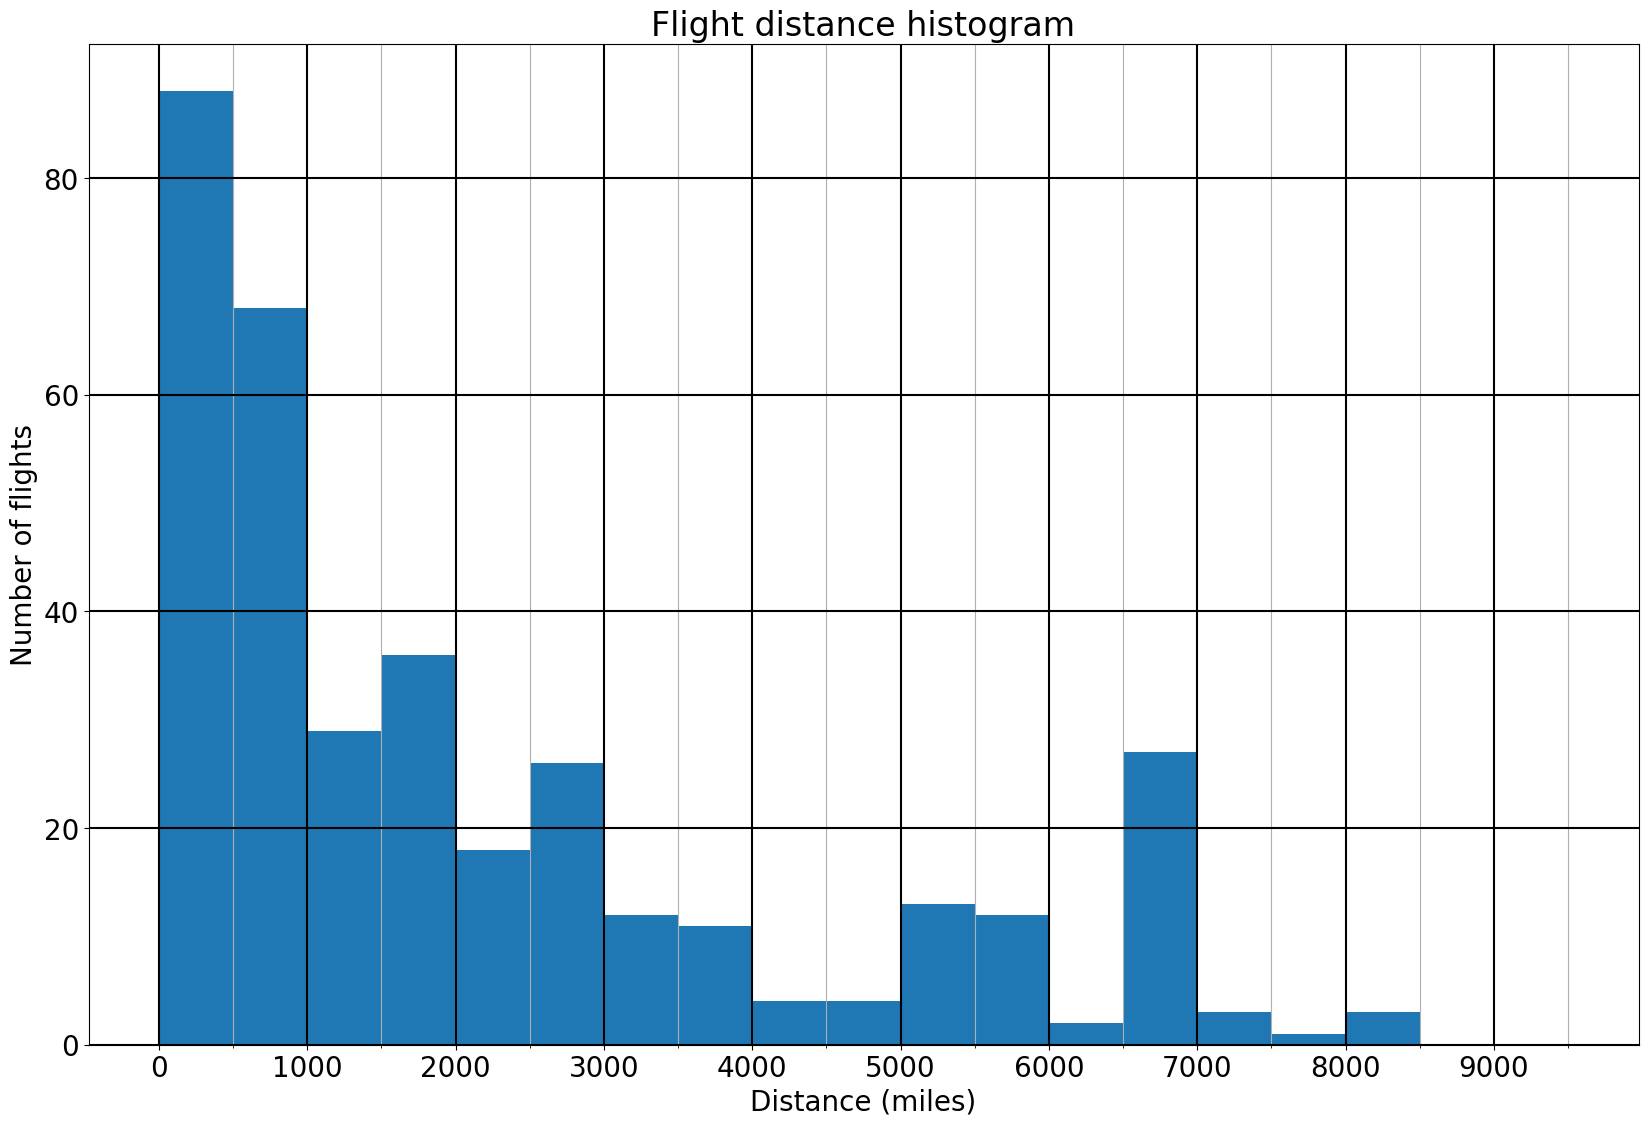

In [60]:
df['Sorted Route'] = df.apply(lambda row: str(sorted([row['Dep Airport'], row['Arr Airport']])[0]) + ' ' + str(sorted([row['Dep Airport'], row['Arr Airport']])[1]), axis=1)
routes_sorted = df.groupby('Sorted Route').agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
route_distance_cols = ['Dep Airport', 'Arr Airport', 'Dep Country', 'Arr Country', 'Distance_x', 'Date_y', 'Distance_y']

fig, ax = plt.subplots(1, 1, figsize=(20,13))
bins = list(range(0, 10000, 500))
ax.hist(df['Distance'], bins=bins)
ax.set_xticks(bins, minor=True)
ax.set_xticks([b for i, b in enumerate(bins) if i%2 == 0])
ax.grid(which='major', linewidth=1.5, color='black')
ax.grid(which='minor', axis='both')
ax.set_xlabel('Distance (miles)')
ax.set_ylabel('Number of flights')
ax.set_title('Flight distance histogram')
plt.savefig(ROOT_DIR + 'figures/distance_hist.jpg', bbox_inches='tight')

longest_flights = df.sort_values(['Distance'], ascending=False).drop_duplicates(subset='Distance').head(20)
longest_flights = longest_flights.merge(routes_sorted, on='Sorted Route')
longest_flights.reset_index()[route_distance_cols]
                                                                                        


In [61]:
# Shortest flights
shortest_flights = df.sort_values(['Distance'], ascending=True).drop_duplicates(subset='Distance').head(20)
shortest_flights = shortest_flights.merge(routes_sorted, on='Sorted Route')
shortest_flights.reset_index()[route_distance_cols]
                                                     

Dep Airport Arr Airport     Dep Country     Arr Country  Distance_x  \
0          PHL         JFK   United States   United States          94   
1          HNL         LIH   United States   United States         102   
2          IAD         PHL   United States   United States         135   
3          IAH         AUS   United States   United States         140   
4          KUL         SIN        Malaysia       Singapore         185   
5          JFK         BOS   United States   United States         187   
6          SEN         CDG  United Kingdom          France         195   
7          LJG         KMG           China           China         199   
8          EWR         BOS   United States   United States         201   
9          AMS         LCY     Netherlands  United Kingdom         209   
10         CDG         LHR          France  United Kingdom         216   
11         LAX         LAS   United States   United States         236   
12         PHL         BOS   United States   United States         280   
13         AMM         PFO          Jordan          Cyprus         290   
14         CAI         AMM           Egypt          Jordan         294   
15         URC         KJI           China           China         299   
16         LIS         MAD        Portugal           Spain         319   
17         BDL         IAD   United States   United States         325   
18         RDU         PHL   United States   United States         337   
19         NAV         IST          Turkey          Turkey         352   

    Date_y  Distance_y  
0        1          94  
1        1         102  
2        1         135  
3        1         140  
4        1         185  
5        1         187  
6        2         390  
7        1         199  
8       26        5226  
9        1         209  
10       2         432  
11       1         236  
12       3         840  
13       1         290  
14       1         294  
15       4        1196  
16       1         319  
17       1         325  
18       1         337  
19       2         704

In [62]:
# Longest domestic
longest_domestic = df[df['Domestic/International']=='Domestic'].sort_values('Distance', ascending=False).drop_duplicates(subset='Distance').head(30)
longest_domestic = longest_domestic.merge(routes_sorted, on='Sorted Route')
longest_domestic.reset_index()[route_distance_cols]


Dep Airport Arr Airport    Dep Country    Arr Country  Distance_x  Date_y  \
0          OGG         EWR  United States  United States        4903       1   
1          ORD         HNL  United States  United States        4244       1   
2          HNL         IAH  United States  United States        3904       1   
3          DEN         OGG  United States  United States        3302       1   
4          SFO         BOS  United States  United States        2704       9   
5          LAX         BOS  United States  United States        2611       3   
6          JFK         SFO  United States  United States        2586       3   
7          EWR         SFO  United States  United States        2565       6   
8          PHL         SFO  United States  United States        2521       2   
9          LAX         EWR  United States  United States        2454       1   
10         LIH         SFO  United States  United States        2447       1   
11         IAD         SFO  United States  United States        2419       1   
12         DEN         ANC  United States  United States        2405       2   
13         EWR         SEA  United States  United States        2402       1   
14         SFO         HNL  United States  United States        2399       1   
15         SFO         TPA  United States  United States        2393       2   
16         KOA         SFO  United States  United States        2367       2   
17         IAD         LAX  United States  United States        2288       1   
18         SHA         URC          China          China        2037       1   
19         SFO         ORD  United States  United States        1846       1   
20         BOS         DEN  United States  United States        1754       4   
21         ORD         LAX  United States  United States        1745       1   
22         DEN         BDL  United States  United States        1671       1   
23         SFO         IAH  United States  United States        1635       3   
24         LGA         DEN  United States  United States        1620       1   
25         IAH         BOS  United States  United States        1597       1   
26         PEK         SYX          China          China        1560       4   
27         URC         PKX          China          China        1519       1   
28         URC         PEK          China          China        1514       2   
29         AUS         SFO  United States  United States        1504       1   

    Distance_y  
0         4903  
1         4244  
2         3904  
3         3302  
4        24336  
5         7833  
6         7758  
7        15390  
8         5042  
9         2454  
10        2447  
11        2419  
12        4810  
13        2402  
14        2399  
15        4786  
16        4734  
17        2288  
18        2037  
19        1846  
20        7016  
21        1745  
22        1671  
23        4905  
24        1620  
25        1597  
26        6240  
27        1519  
28        3028  
29        1504

In [63]:
# Shortest international
shortest_international = df[df['Domestic/International']=='International'].sort_values('Distance', ascending=True).drop_duplicates(subset='Distance').head(20)
shortest_international = shortest_international.merge(routes_sorted, on='Sorted Route')
shortest_international.reset_index()[route_distance_cols]


Dep Airport Arr Airport     Dep Country     Arr Country  Distance_x  \
0          KUL         SIN        Malaysia       Singapore         185   
1          CDG         SEN          France  United Kingdom         195   
2          AMS         LCY     Netherlands  United Kingdom         209   
3          CDG         LHR          France  United Kingdom         216   
4          AMM         PFO          Jordan          Cyprus         290   
5          CAI         AMM           Egypt          Jordan         294   
6          LIS         MAD        Portugal           Spain         319   
7          PRG         WAW  Czech Republic          Poland         325   
8          LHR         FRA  United Kingdom         Germany         408   
9          BSL         LGW          France  United Kingdom         426   
10         LHR         BSL  United Kingdom          France         448   
11         AGA         TFS         Morocco           Spain         460   
12         PVG         OKA           China           Japan         492   
13         KIX         ICN           Japan     South Korea         535   
14         LGW         MXP  United Kingdom           Italy         559   
15         ICN         PEK     South Korea           China         562   
16         PEK         GMP           China     South Korea         577   
17         STN         PRG  United Kingdom  Czech Republic         623   
18         SIN         SGN       Singapore         Vietnam         676   
19         BCN         MUC           Spain         Germany         681   

    Date_y  Distance_y  
0        1         185  
1        2         390  
2        1         209  
3        2         432  
4        1         290  
5        1         294  
6        1         319  
7        1         325  
8        1         408  
9        1         426  
10       1         448  
11       1         460  
12       1         492  
13       1         535  
14       1         559  
15       2        1124  
16       2        1154  
17       1         623  
18       2        1352  
19       1         681

# FLIGHTS SORTED BY DURATION

Date Scheduled Dep Time (Local) Scheduled Arr Time (Local)  \
218 2022-11-10        2022-11-10 10:40:00        2022-11-11 20:15:00   
221 2022-11-28        2022-11-28 10:15:00        2022-11-28 08:50:00   
355 2026-01-12        2026-01-12 08:25:00        2026-01-12 14:55:00   
72  2018-01-07        2018-01-07 10:00:00        2018-01-07 08:40:00   
74  2018-03-22        2018-03-22 16:35:00        2018-03-23 19:20:00   
75  2018-03-29        2018-03-29 12:25:00        2018-03-29 14:35:00   
98  2019-01-06        2019-01-06 23:55:00        2019-01-07 05:05:00   
260 2023-09-30        2023-09-30 23:20:00        2023-10-02 05:00:00   
0   2015-01-03        2015-01-03 13:45:00        2015-01-03 14:10:00   
126 2019-12-18        2019-12-18 20:30:00        2019-12-19 18:00:00   
2   2015-03-08        2015-03-08 12:55:00        2015-03-09 15:00:00   
21  2016-06-05        2016-06-05 17:10:00        2016-06-06 19:05:00   
13  2016-03-13        2016-03-13 16:50:00        2016-03-14 19:05:00   
279 2024-01-29        2024-01-29 13:35:00        2024-01-30 19:50:00   
8   2015-12-18        2015-12-18 12:00:00        2015-12-19 15:00:00   
114 2019-08-17        2019-08-17 11:50:00        2019-08-18 13:35:00   
61  2017-10-07        2017-10-07 11:45:00        2017-10-08 13:35:00   
88  2018-10-03        2018-10-03 11:45:00        2018-10-04 13:35:00   
95  2018-12-22        2018-12-22 10:55:00        2018-12-23 15:00:00   
28  2016-12-15        2016-12-15 12:00:00        2016-12-16 15:00:00   

    Actual Duration     Airline  Flight Dep Airport Arr Airport  Distance  \
218 0 days 16:09:00      United    UA29         SFO         SIN      8446   
221 0 days 14:33:00      United     UA2         SIN         SFO      8446   
355 0 days 14:30:00       Japan    JL45         HND         CDG      6046   
72  0 days 14:09:00      United     UA2         SIN         SFO      8446   
74  0 days 14:03:00      Hainan  HU7962         BOS         PVG      7308   
75  0 days 14:03:00      Hainan  HU7961         PVG         BOS      7308   
98  0 days 13:50:00  Air Canada    AC57         DXB         YYZ      6899   
260 0 days 13:35:00      United   UA877         SFO         HKG      6927   
0   0 days 13:34:00      Hainan   HU481         PEK         BOS      6737   
126 0 days 13:33:00      United  UA1122         EWR         CPT      7817   
2   0 days 13:30:00      United    UA89         EWR         PEK      6831   
21  0 days 13:29:00      Hainan   HU482         BOS         PEK      6737   
13  0 days 13:26:00      Hainan   HU482         BOS         PEK      6737   
279 0 days 13:23:00      United   UA871         SFO         TPE      6469   
8   0 days 13:22:00      United    UA89         EWR         PEK      6831   
114 0 days 13:17:00      United    UA89         EWR         PEK      6831   
61  0 days 13:15:00      United    UA89         EWR         PEK      6831   
88  0 days 13:15:00      United    UA89         EWR         PEK      6831   
95  0 days 13:13:00      United    UA79         EWR         NRT      6732   
28  0 days 13:11:00      United    UA89         EWR         PEK      6831   

     Dep Delay (min)  Dep Delay (min)              Class Aircraft Registration  
218             50.0             50.0            Economy     B789       N28987  
221             13.0             13.0            Economy     B789       N29985  
355              0.0              0.0  Lie-flat Business      NaN          NaN  
72              20.0             20.0  Lie-flat Business     B789       N38955  
74              14.0             14.0            Economy     B788        B2750  
75              26.0             26.0            Economy     B789        B7835  
98              74.0             74.0  Lie-flat Business     B77W        CFRAM  
260             34.0             34.0            Economy     B77W       N2747U  
0               10.0             10.0            Economy      NaN          NaN  
126            134.0            134.0  Lie-flat Business     B789    

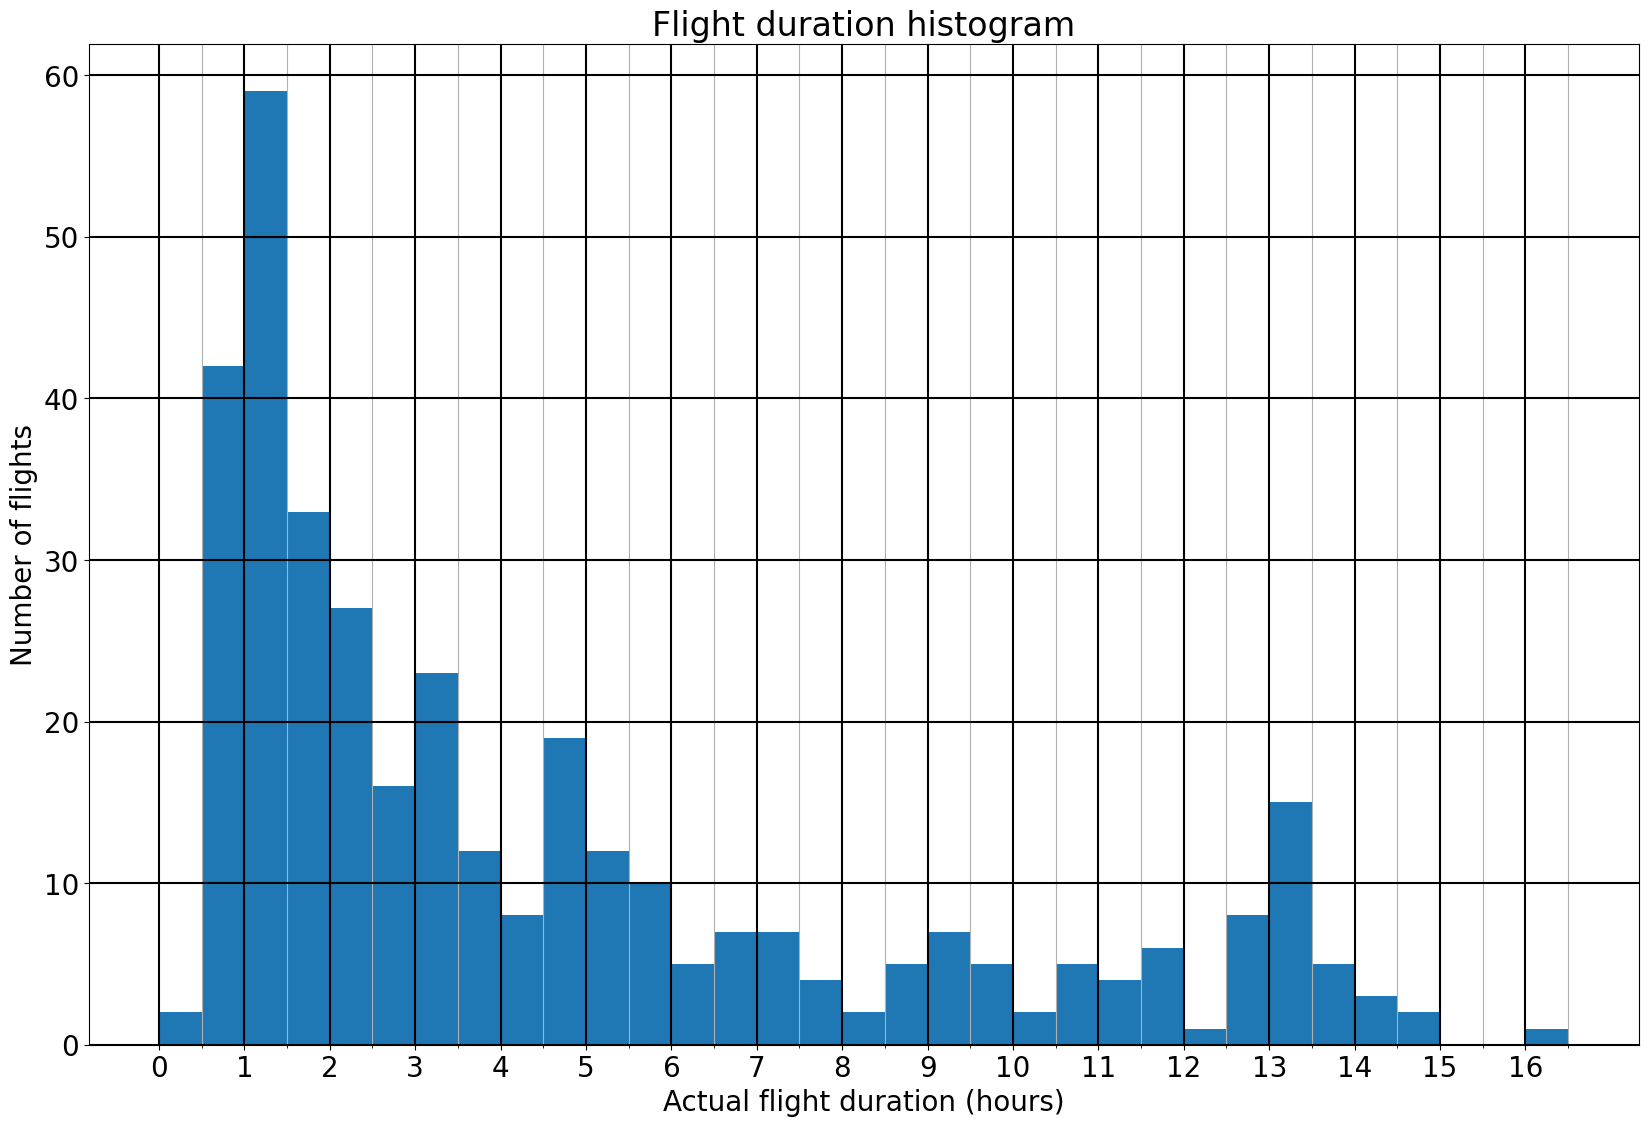

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(20,13))
bins = list(range(0, math.ceil(df['Actual Duration (min)'].max()/30)*30+30, 30))
ax.hist(df['Actual Duration (min)'], bins=bins)
ax.set_xticks(bins, minor=True)
ax.set_xticks([b for i, b in enumerate(bins) if i%2 == 0])
ax.set_xticklabels([b//60 for i, b in enumerate(bins) if i%2 == 0])
ax.grid(which='major', linewidth=1.5, color='black')
ax.grid(which='minor', axis='both')
ax.set_xlabel('Actual flight duration (hours)')
ax.set_ylabel('Number of flights')
ax.set_title('Flight duration histogram')
plt.savefig(ROOT_DIR + 'figures/duration_hist.jpg', bbox_inches='tight')

df.sort_values(['Actual Duration (min)'], ascending=False).head(20)[important_cols]

# TOP AIRLINES

In [65]:
airlines = df.groupby('Airline').agg({'Flight': 'count', 'Actual Duration (min)': sum, 'Distance': sum})
airlines = airlines.sort_values(by='Flight', ascending=False)
airlines.head(20)

/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/1316924436.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  airlines = df.groupby('Airline').agg({'Flight': 'count', 'Actual Duration (min)': sum, 'Distance': sum})


Flight  Actual Duration (min)  Distance
Airline                                                 
United              158                51023.0    429844
Air China            25                 6505.0     48125
Hainan               14                 6244.0     50973
China Southern       11                 1261.0      8980
Lufthansa            10                 3533.0     30640
Ryanair              10                 1505.0     10195
JetBlue               9                 1846.0     14963
TAP                   8                 2664.0     21505
Delta                 8                  608.0      4032
British Airways       7                  876.0      5138
China Eastern         5                  583.0      4002
American              5                  652.0      4662
Alaska                5                  685.0      4696
LOT                   4                 1455.0      9893
EasyJet               4                  250.0      1375
Etihad                4                 1863.0     14262
Sichuan               4                  814.0      6520
Vueling               3                  311.0      2023
Air New Zealand       3                  613.0      5489
Turkish               3                  676.0      5718

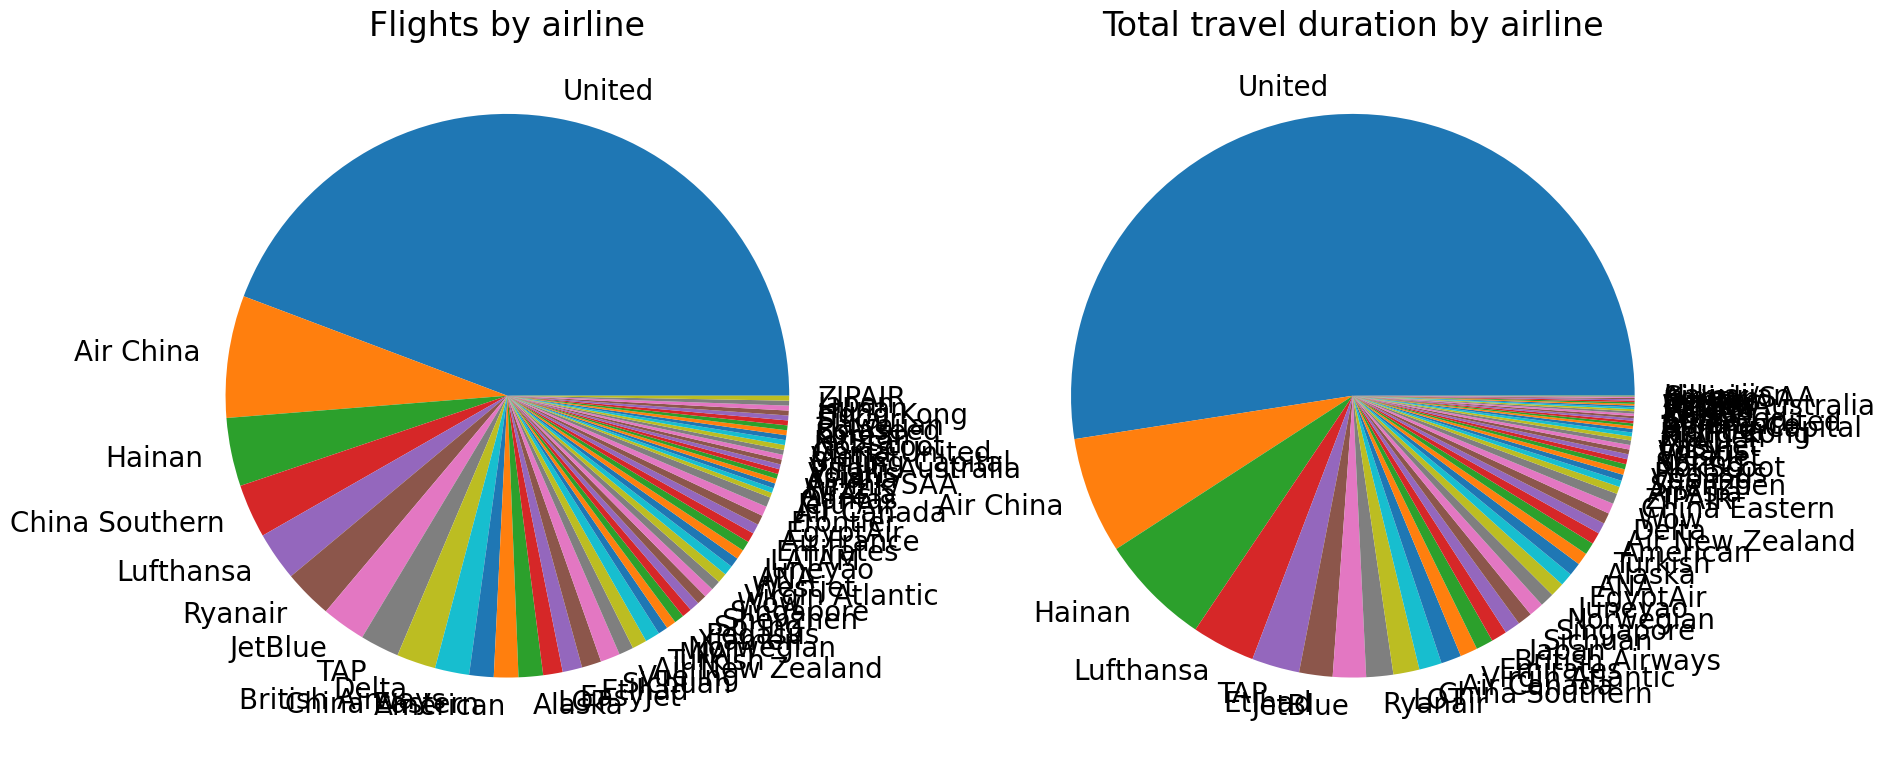

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
airlines.plot('Airline', 'Flight', kind='pie', legend=False, ax=ax[0])
airlines.sort_values(by='Actual Duration (min)', ascending=False).plot('Airline', 'Actual Duration (min)', kind='pie', legend=False, ax=ax[1])
ax[0].set_title('Flights by airline')
ax[1].set_title('Total travel duration by airline')
ax[0].set_ylabel('')
ax[1].set_ylabel('')
plt.savefig(ROOT_DIR + 'figures/airlines.jpg', bbox_inches='tight')


# TOP AIRCRAFT

In [67]:
aircraft = df.groupby(['Aircraft']).agg({'Date': 'count', 'Distance': sum, 'Actual Duration (min)': sum}).sort_values(by='Date', ascending=False)
aircraft.columns = ['Count', 'Total Distance', 'Actual Duration (min)']
aircraft

/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/2950470887.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  aircraft = df.groupby(['Aircraft']).agg({'Date': 'count', 'Distance': sum, 'Actual Duration (min)': sum}).sort_values(by='Date', ascending=False)


Count  Total Distance  Actual Duration (min)
Aircraft                                              
B738         52           59157                 8199.0
A320         38           27453                 3940.0
B772         30          165145                18935.0
B789         24          114010                13112.0
B739         18           14166                 1998.0
A321         17           22110                 2908.0
A319         16           11775                 1713.0
B77W         14           61236                 7117.0
B752         13           34880                 4220.0
B737         12            8163                 1326.0
B788         11           50487                 6203.0
A21N         10           12156                 1709.0
E75L          9            4930                  739.0
A333          9           15486                 2164.0
A20N          7            7508                 1109.0
B39M          7           12710                 1637.0
B38M          7            8673                 1181.0
B763          6           23114                 2696.0
A359          5           26959                 2997.0
E170          4            1893                  319.0
A388          4           14454                 1696.0
E190          4            1573                  241.0
A339          3           14627                 1708.0
CRJ2          2            1034                  159.0
B78X          2            6324                  725.0
CRJ9          2             281                   70.0
737           2            1835                  271.0
B753          2            2905                  338.0
B744          2           10249                 1146.0
B748          1            5699                  596.0
BCS1          1             588                   82.0
B734          1             201                   42.0
CRJ7          1             135                   33.0
B733          1             201                   54.0
B712          1             102                   24.0
A332          1            3192                  350.0
E195          1            1145                  152.0
A330          1            2733                  354.0
E75S          1             325                   55.0

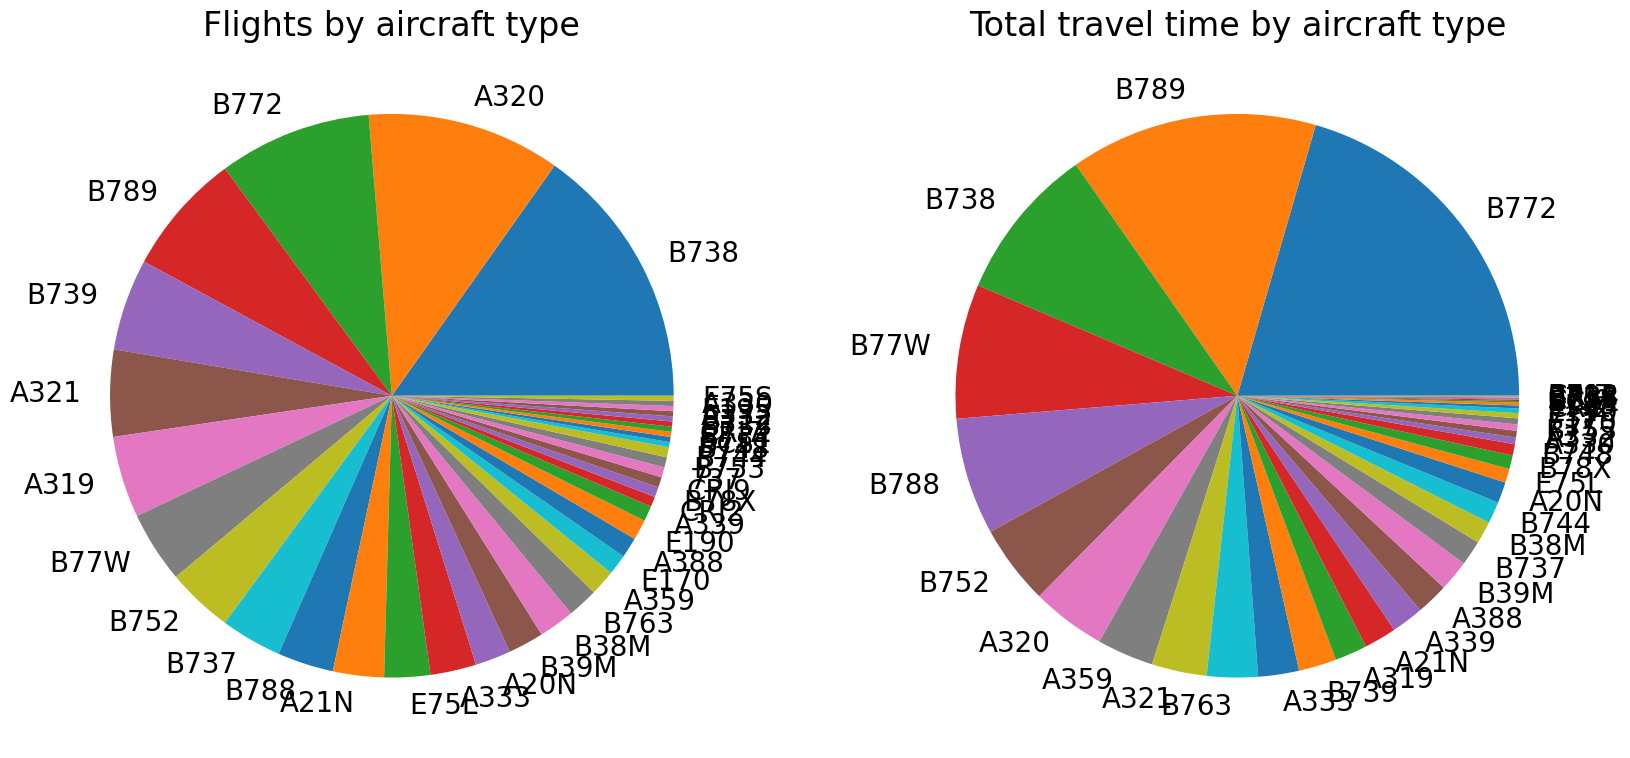

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
aircraft.plot('Aircraft', 'Count', kind='pie', legend=False, ax=ax[0])
aircraft.sort_values(by='Actual Duration (min)', ascending=False).plot('Aircraft', 'Actual Duration (min)', kind='pie', legend=False, ax=ax[1])
ax[0].set_title('Flights by aircraft type')
ax[1].set_title('Total travel time by aircraft type')
ax[0].set_ylabel('')
ax[1].set_ylabel('')
plt.savefig(ROOT_DIR + 'figures/aircrafts.jpg', bbox_inches='tight')


# TOP AIRCRAFT REGS

In [69]:
reg = df.groupby(['Registration', 'Aircraft']).agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False).head(15)
reg.columns = ['Count', 'Total Distance']
reg

/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3490438783.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  reg = df.groupby(['Registration', 'Aircraft']).agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False).head(15)


Count  Total Distance
Registration Aircraft                       
N78005       B772          3           20493
N76010       B772          3           20178
N26232       B738          2            2400
N975JT       A321          2            3228
B2750        B788          2           14045
B5957        A333          2            4968
N78008       B772          2           13662
B7880        B789          2            1364
N76021       B772          2            9396
N68842       B739          2            2315
N48127       B752          2            6048
N458UA       A320          2             847
N37018       B772          2           12489
N36962       B789          2           12856
N19136       B752          2            5408

# TRAVEL BY YEAR

In [70]:
dist_year = df.groupby(df['Date'].dt.year).agg({'Distance': sum, 'Actual Duration (min)': sum, 'Date': 'count'})
dist_year.columns = ['Distance', 'Actual Duration (min)', 'Flights']
missing_years = set(range(dist_year.index.min(), dist_year.index.max())) - set(dist_year.index)
for yr in missing_years:
    dist_year = dist_year.append(pd.DataFrame({'Distance': 0, 'Actual Duration (min)': 0, 'Flights': 0}, index=[yr]))
dist_year

/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/2651100000.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dist_year = df.groupby(df['Date'].dt.year).agg({'Distance': sum, 'Actual Duration (min)': sum, 'Date': 'count'})


Distance  Actual Duration (min)  Flights
Date                                          
2015     36175                 4426.0       11
2016     58573                 7009.0       22
2017     78052                 9500.0       39
2018     77926                 9282.0       26
2019     84246                10087.0       32
2020     48041                 6064.0       30
2021     58953                 7404.0       33
2022     88374                10323.0       35
2023     84550                10962.0       44
2024    106414                13320.0       46
2025     49941                 6725.0       32
2026     14483                 2155.0        7

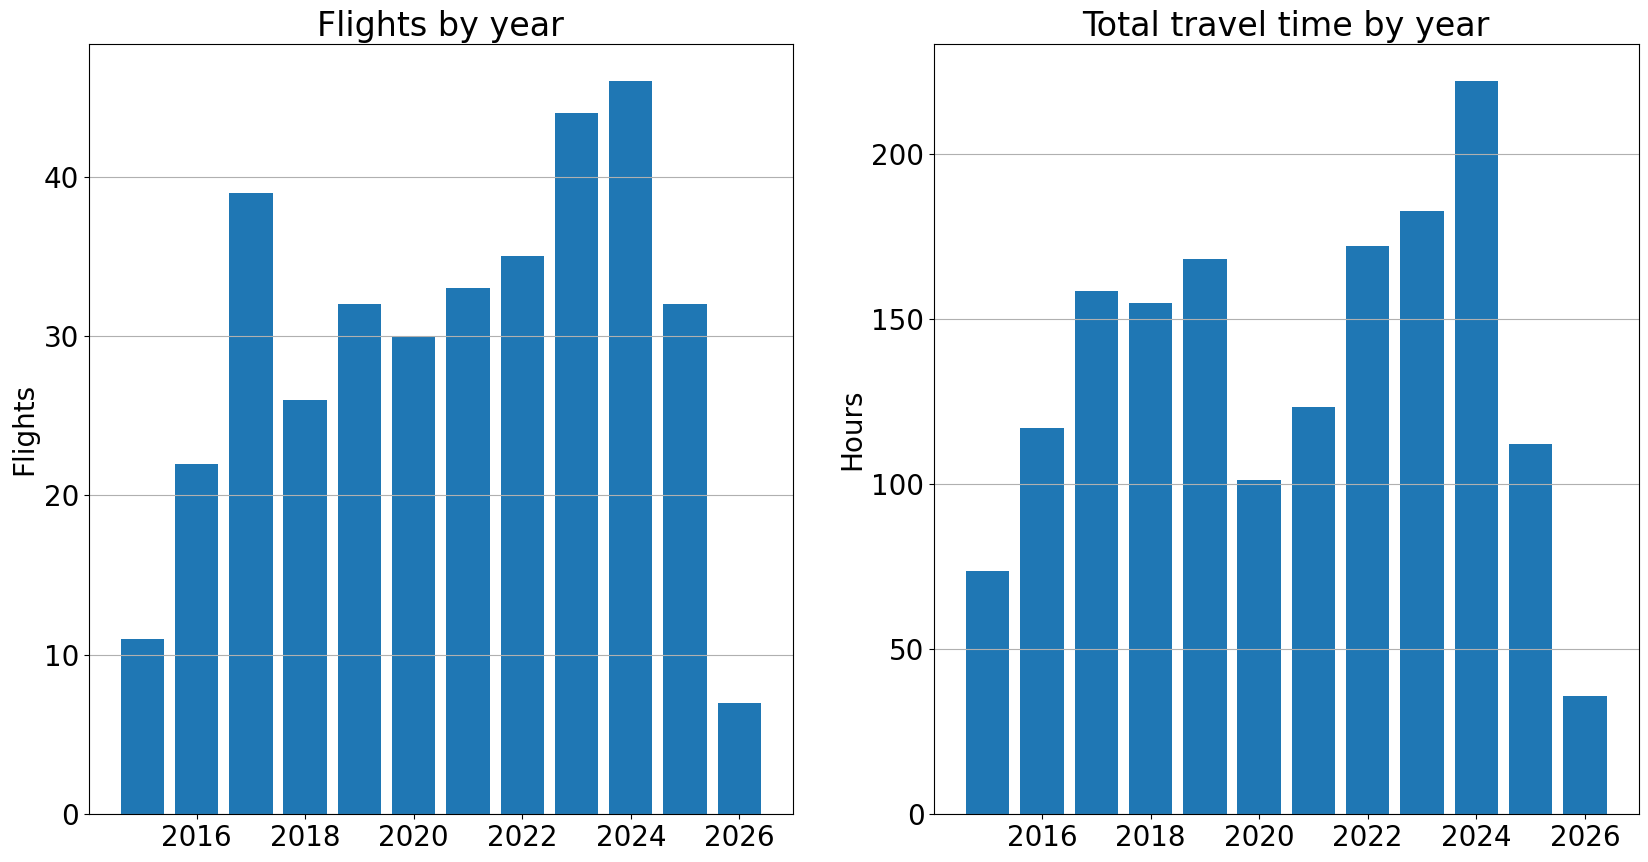

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].bar(dist_year.index, dist_year['Flights'])
ax[0].grid(axis='y')
ax[0].set_title('Flights by year')
ax[0].set_ylabel('Flights')
ax[1].bar(dist_year.index, dist_year['Actual Duration (min)']/60)
ax[1].grid(axis='y')
ax[1].set_title('Total travel time by year')
ax[1].set_ylabel('Hours')
plt.savefig(ROOT_DIR + 'figures/by_year.jpg', bbox_inches='tight')


# TRAVEL BY MONTH

In [72]:
df['Month'] = df['Date']
dist_yearm = df.groupby([df['Date'].dt.year, df['Month'].dt.month]).agg({'Distance': sum, 'Actual Duration (min)': sum, 'Date': 'count'})
dist_yearm.columns = ['Distance', 'Actual Duration (min)', 'Flights']

dist_yearm.sort_values(by='Distance', ascending=False).head(30)

/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/1669114295.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dist_yearm = df.groupby([df['Date'].dt.year, df['Month'].dt.month]).agg({'Distance': sum, 'Actual Duration (min)': sum, 'Date': 'count'})


Distance  Actual Duration (min)  Flights
Date Month                                          
2024 4         23585                 2730.0        8
2019 12        20872                 2402.0        7
2024 1         20637                 2830.0        8
2021 6         18559                 2312.0       10
2022 11        18244                 2032.0        4
2023 3         18179                 2233.0        7
     9         17879                 2069.0        4
2022 2         17772                 2054.0        6
2016 3         17482                 2157.0        8
2018 3         17029                 1969.0        3
2024 5         16902                 1854.0        4
2022 12        16797                 1912.0        6
2025 4         16470                 2137.0        8
2019 8         15448                 1750.0        3
2022 10        15008                 1770.0        6
2025 12        14894                 1970.0        7
2020 1         14596                 1781.0        8
2021 11        14546                 1795.0        6
2026 1         14483                 2155.0        7
2017 10        14366                 1696.0        4
2016 12        14233                 1762.0        6
2018 10        14064                 1668.0        4
2015 3         14064                 1673.0        4
2017 3         14064                 1610.0        4
2023 12        13636                 1983.0        7
2016 7         12787                 1462.0        5
2018 12        11673                 1550.0        3
     1         11150                 1152.0        2
2024 7         10367                 1261.0        6
2015 12        10152                 1320.0        4

In [73]:
import pandas as pd

def calculate_30_day_windows(df):
    # Ensure Date column is datetime and sort
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    windows = []
    unique_dates = df['Date'].unique()

    for start_date in unique_dates:
        end_date = start_date + pd.Timedelta(days=31)

        # Get flights in this 30-day window
        window_flights = df[(df['Date'] >= start_date) & (df['Date'] < end_date)]

        if len(window_flights) == 0:
            continue

        # Create flight signature for duplicate detection
        signature = tuple(sorted(zip(
            window_flights['Date'].dt.strftime('%Y-%m-%d'),
            window_flights['Flight'].astype(str),
            window_flights['Dep Airport'].astype(str),
            window_flights['Arr Airport'].astype(str)
        )))

        windows.append({
            'window_start': start_date,
            'window_end': end_date,
            'num_flights': len(window_flights),
            'total_distance': window_flights['Distance'].sum(),
            'total_duration_min': window_flights['Actual Duration (min)'].sum(),
            'flight_signature': signature
        })

    # Convert to DataFrame and remove duplicates and subsets
    windows_df = pd.DataFrame(windows)
    if not windows_df.empty:
        # First remove exact duplicates
        windows_df = windows_df.drop_duplicates(subset=['flight_signature'])

        # Remove windows that are strict subsets of other windows
        to_remove = []
        for i, row1 in windows_df.iterrows():
            sig1 = set(row1['flight_signature'])
            for j, row2 in windows_df.iterrows():
                if i != j and i not in to_remove:
                    sig2 = set(row2['flight_signature'])
                    # If sig1 is a strict subset of sig2, mark for removal
                    if sig1.issubset(sig2) and sig1 != sig2:
                        to_remove.append(i)
                        break

        # Remove subset windows
        windows_df = windows_df.drop(to_remove).drop('flight_signature', axis=1)
        windows_df = windows_df.sort_values('window_start').reset_index(drop=True)

    return windows_df

# Usage:
windows = calculate_30_day_windows(df)

# Sort by any metric you want:
# windows.sort_values('total_duration_min', ascending=False)  # Top by duration
# windows.sort_values('num_flights', ascending=False)         # Top by flight count
windows.sort_values('total_distance', ascending=False).head(20)      # Top by distance

window_start window_end  num_flights  total_distance  total_duration_min
107   2025-12-13 2026-01-13           13           28596              3985.0
65    2022-11-27 2022-12-28            8           25919              2879.0
93    2024-04-10 2024-05-11            7           24362              2738.0
7     2016-12-15 2017-01-15            8           24332              2829.0
92    2024-04-04 2024-05-05            9           24126              2753.0
91    2024-04-01 2024-05-02            8           23585              2730.0
106   2025-12-12 2026-01-12           12           23115              3180.0
36    2019-12-28 2020-01-28           10           22969              2736.0
62    2022-10-13 2022-11-13            5           22674              2605.0
31    2019-11-21 2019-12-22            9           21997              2622.0
94    2024-04-23 2024-05-24            5           21982              2419.0
85    2024-01-02 2024-02-02            9           21705              2992.0
32    2019-11-28 2019-12-29            8           21324              2500.0
49    2021-05-26 2021-06-26           11           21294              2603.0
34    2019-12-18 2020-01-18            8           20967              2408.0
17    2017-12-19 2018-01-19            5           20962              2337.0
33    2019-12-02 2020-01-02            7           20872              2402.0
23    2018-12-22 2019-01-22            5           20831              2683.0
63    2022-11-10 2022-12-11            5           20643              2320.0
18    2018-03-22 2018-04-22            4           19442              2273.0

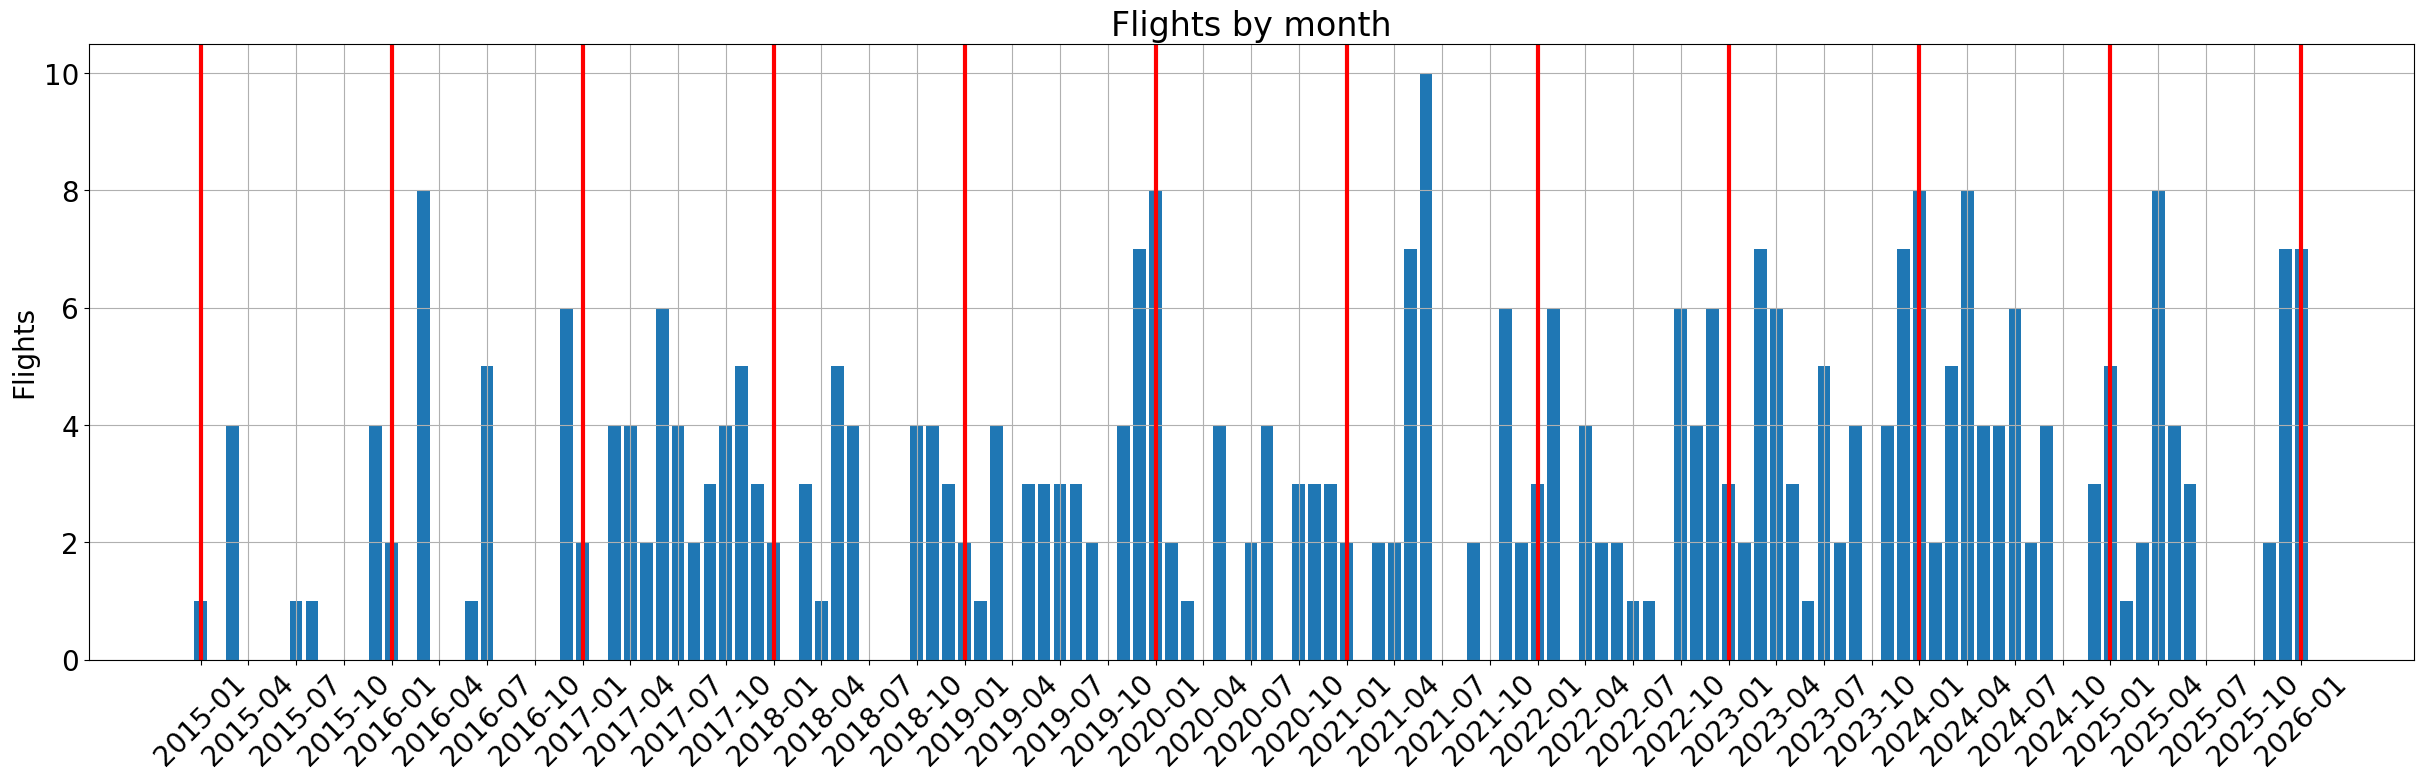

In [74]:
months = df['Month'].sort_values()
start_month = months.iloc[0]
end_month = months.iloc[-1]

index = pd.period_range(start_month, end_month, freq='M')
index_str = pd.DataFrame(index.astype(str), columns=['Y-M'])
# dist_yearm.reindex(index)

a = dist_yearm.reset_index()
a['Date'] = a['Date'].astype('int32').astype(str)
a['Month'] = a['Month'].astype('str').str.zfill(2)

a['Y-M'] = a['Date'] + '-' + a['Month']
a = a.merge(index_str, how='outer').sort_values(['Y-M']).fillna(0)

fig, ax = plt.subplots(figsize=(30,8))
ax.bar(a['Y-M'], a['Flights'], linewidth=5)
ticks = [x for i, x in enumerate(list(a['Y-M'])) if i % 3 == 0]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, rotation=45)
ax.set_ylabel('Flights')
ax.set_title('Flights by month')
ax.grid(True)


for year in range(df['Date'].dt.year.min(), df['Date'].dt.year.max()+1): 
    if str(year) + '-01' in a['Y-M'].tolist():
        ax.axvline(str(year) + '-01', linewidth=3, color='red')
        
plt.savefig(ROOT_DIR + 'figures/flights_by_month.jpg', bbox_inches='tight')


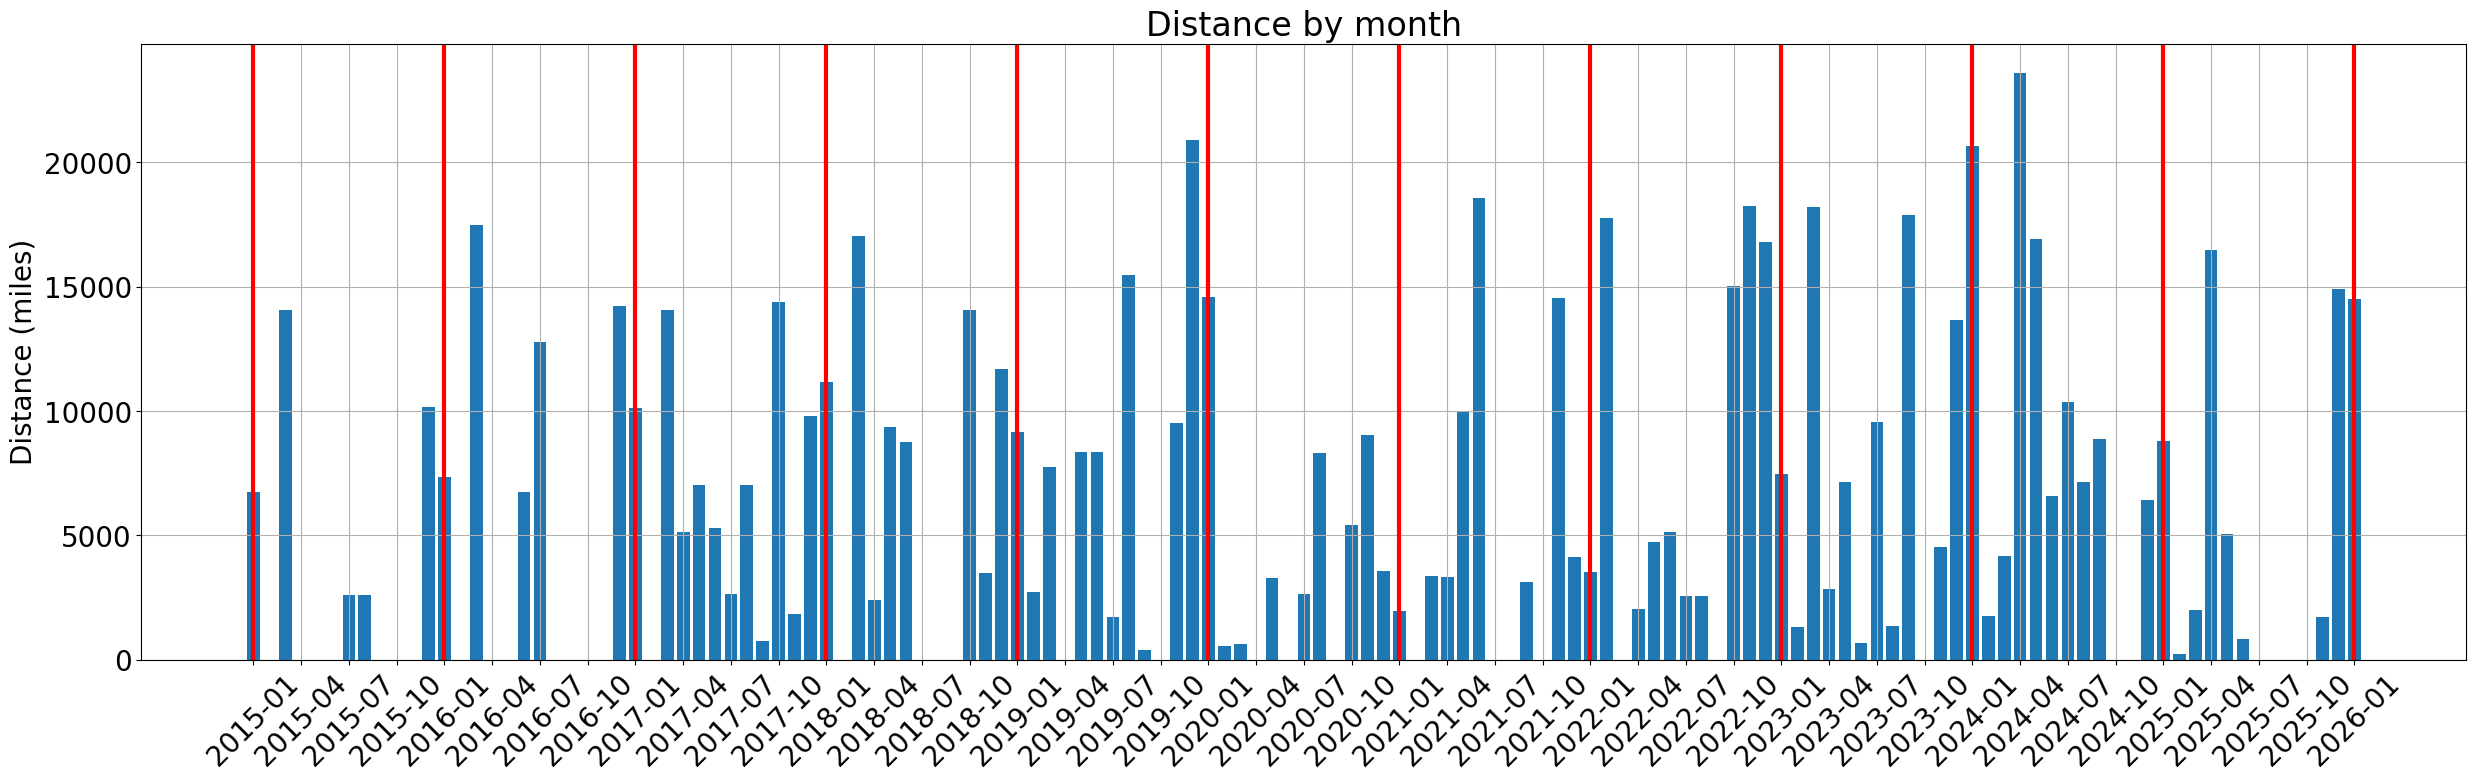

In [75]:
fig, ax = plt.subplots(figsize=(30,8))
ax.bar(a['Y-M'], a['Distance'], linewidth=5)
ticks = [x for i, x in enumerate(list(a['Y-M'])) if i % 3 == 0]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, rotation=45)
ax.set_ylabel('Distance (miles)')
ax.set_title('Distance by month')
ax.grid(True)


for year in range(df['Date'].dt.year.min(), df['Date'].dt.year.max()+1): 
    if str(year) + '-01' in a['Y-M'].tolist():
        ax.axvline(str(year) + '-01', linewidth=3, color='red')
        
plt.savefig(ROOT_DIR + 'figures/distance_month.jpg', bbox_inches='tight')

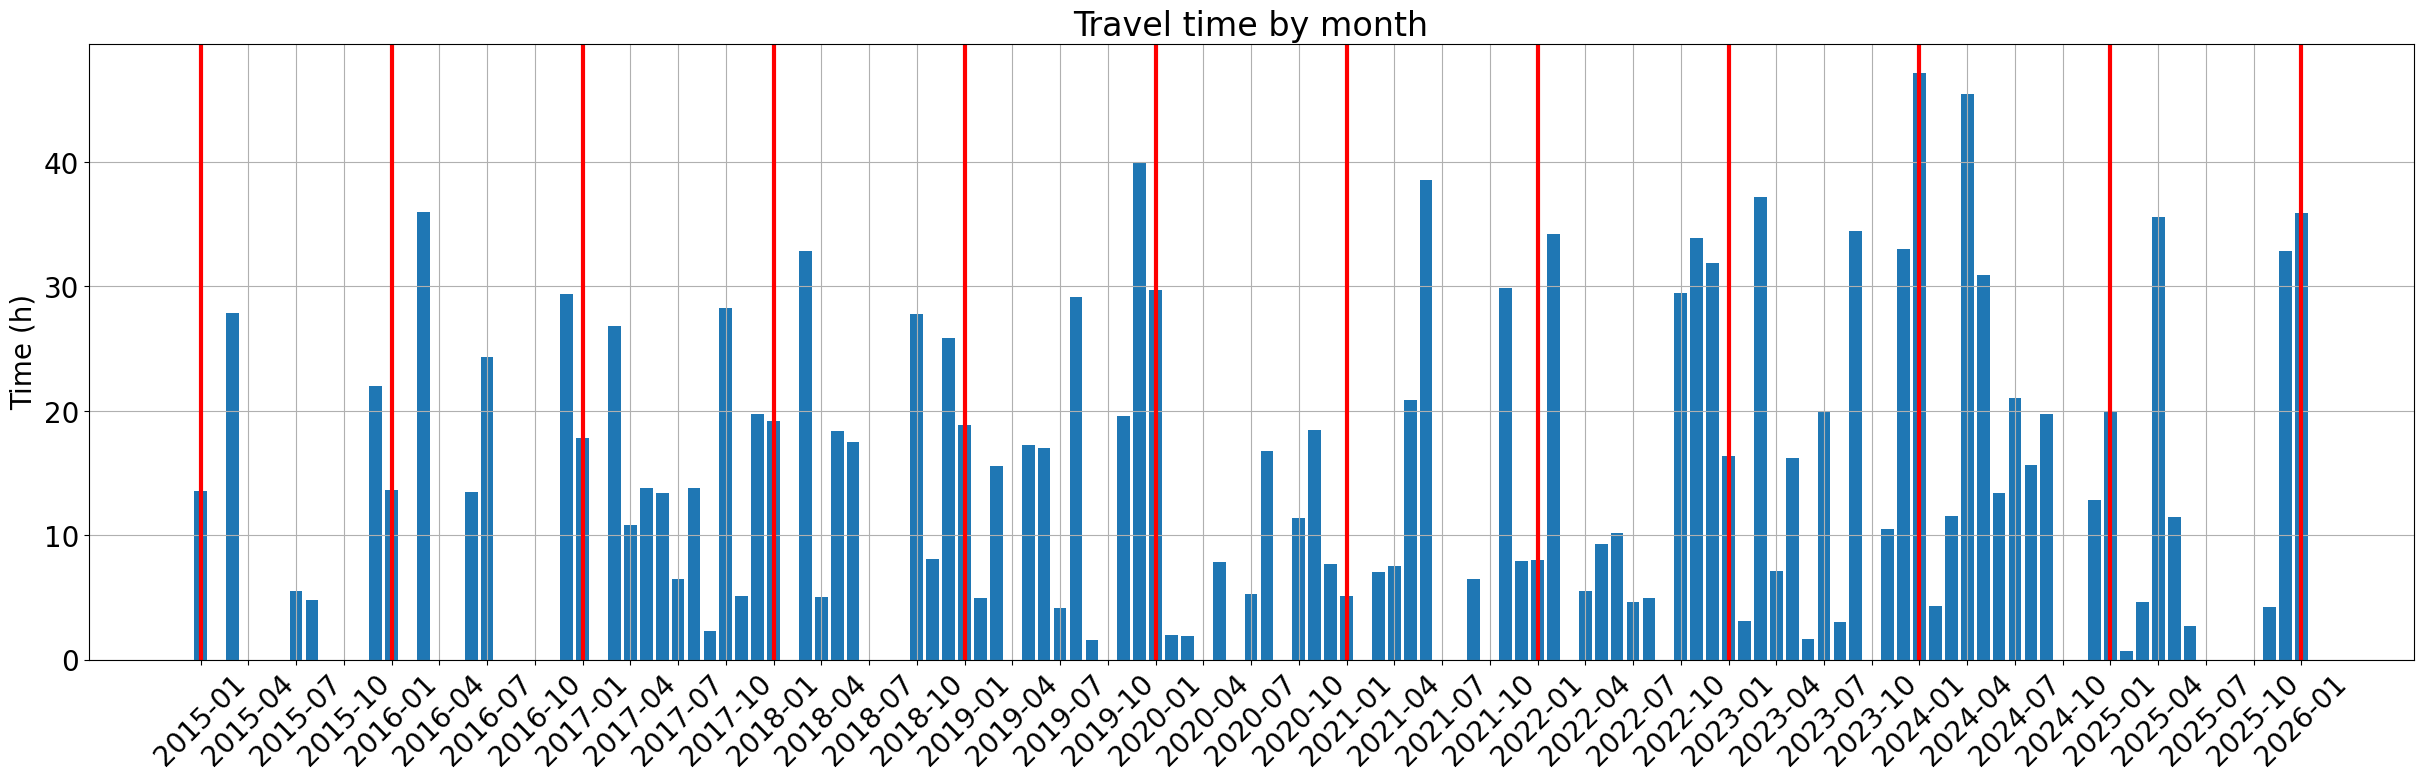

In [76]:
fig, ax = plt.subplots(figsize=(30,8))
ax.bar(a['Y-M'], a['Actual Duration (min)']/60, linewidth=5)
ticks = [x for i, x in enumerate(list(a['Y-M'])) if i % 3 == 0]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, rotation=45)
ax.set_ylabel('Time (h)')
ax.set_title('Travel time by month')
ax.grid(True)


for year in range(df['Date'].dt.year.min(), df['Date'].dt.year.max()+1): 
    if str(year) + '-01' in a['Y-M'].tolist():
        ax.axvline(str(year) + '-01', linewidth=3, color='red')
        
plt.savefig(ROOT_DIR + 'figures/time_month.jpg', bbox_inches='tight')

# DOMESTIC AND INTERNATIONAL BREAKDOWN

In [77]:
dom_int = df.groupby('Domestic/International').agg({'Distance': sum, 'Date': 'count'})
dom_int.columns = ['Distance', 'Flights']
dom_int

/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/1625653085.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dom_int = df.groupby('Domestic/International').agg({'Distance': sum, 'Date': 'count'})


Distance  Flights
Domestic/International                   
Domestic                  200620      185
International             585108      172

In [78]:
print('Domestic average dist: ' + str(dom_int.loc['Domestic', 'Distance'] / dom_int.loc['Domestic', 'Flights']))
print('International average dist: ' + str(dom_int.loc['International', 'Distance'] / dom_int.loc['International', 'Flights']))

Domestic average dist: 1084.4324324324325
International average dist: 3401.7906976744184


In [79]:
year_dom_int = df.groupby([df['Date'].dt.year, 'Domestic/International']).agg({'Distance': sum, 'Date': 'count'})
year_dom_int.columns = ['Distance', 'Flights']
year_dom_int = year_dom_int.reset_index()

# fig, ax = plt.subplots(figsize=(30,8))
# ax.bar(year_dom_int['Date'], year_dom_int['Date'], linewidth=5)
# # ticks = [x for i, x in enumerate(list(a['Y-M'])) if i % 3 == 0]
# # ax.set_xticks(ticks)
# # ax.set_xticklabels(ticks, rotation=45)
# # ax.set_ylabel('Flights')
# # ax.set_title('Flights by month')
# # ax.grid(True)

# plt.savefig('figures/domestic_international_year.jpg', bbox_inches='tight')

/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/717766952.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  year_dom_int = df.groupby([df['Date'].dt.year, 'Domestic/International']).agg({'Distance': sum, 'Date': 'count'})


In [80]:
dom_int_country = df[df['Domestic/International'] == 'Domestic'].groupby('Dep Country').agg({'Distance': sum, 'Date': 'count'})
dom_int_country.columns = ['Distance', 'Flights']
dom_int_country.sort_values('Distance', ascending=False)

/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/4001385294.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dom_int_country = df[df['Domestic/International'] == 'Domestic'].groupby('Dep Country').agg({'Distance': sum, 'Date': 'count'})


Distance  Flights
Dep Country                     
United States    155566      126
China             38266       44
New Zealand        1100        2
Japan               966        1
Australia           906        2
France              864        2
Spain               837        2
Peru                728        2
Turkey              704        2
South Africa        403        1
South Korea         280        1

# FARE CLASS BREAKDOWN

In [81]:
clas = df.groupby('Class').agg({'Distance': sum, 'Date': 'count'})
clas.columns = ['Distance', 'Flights']
clas

/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/446002595.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  clas = df.groupby('Class').agg({'Distance': sum, 'Date': 'count'})


Distance  Flights
Class                                 
Economy                558727      283
International First      5699        1
Lie-flat Business      178766       36
Premium Economy         18826        6
Recliner First          23710       31

In [82]:
year_clas = df.groupby([df['Date'].dt.year, 'Class']).agg({'Distance': sum, 'Date': 'count'})
year_clas.columns = ['Distance', 'Flights']
year_clas

/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3273458049.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  year_clas = df.groupby([df['Date'].dt.year, 'Class']).agg({'Distance': sum, 'Date': 'count'})


Distance  Flights
Date Class                                 
2015 Economy                 35773        9
     Recliner First            402        2
2016 Economy                 31518       16
     Lie-flat Business       26854        5
     Recliner First            201        1
2017 Economy                 51109       32
     Lie-flat Business       23930        4
     Recliner First           3013        3
2018 Economy                 59664       19
     Lie-flat Business       14788        3
     Recliner First           3474        4
2019 Economy                 45540       23
     Lie-flat Business       38092        7
     Recliner First            614        2
2020 Economy                 27504       19
     Lie-flat Business       15315        4
     Recliner First           5222        7
2021 Economy                 34462       24
     Lie-flat Business       19675        5
     Premium Economy          2419        1
     Recliner First           2397        3
2022 Economy                 58251       22
     International First      5699        1
     Lie-flat Business        9081        2
     Premium Economy          7529        3
     Recliner First           7814        7
2023 Economy                 67078       38
     Lie-flat Business        8021        2
     Premium Economy          8878        2
     Recliner First            573        2
2024 Economy                 94821       44
     Lie-flat Business       11593        2
2025 Economy                 44570       31
     Lie-flat Business        5371        1
2026 Economy                  8437        6
     Lie-flat Business        6046        1


# CLASS AND TRIP TYPE BREAKDOWN

In [83]:
clas_dom_int = df.groupby(['Domestic/International', 'Class']).agg({'Distance': sum, 'Date': 'count'})
clas_dom_int.columns = ['Distance', 'Flights']
clas_dom_int

/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/1814112429.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  clas_dom_int = df.groupby(['Domestic/International', 'Class']).agg({'Distance': sum, 'Date': 'count'})


Distance  Flights
Domestic/International Class                                 
Domestic               Economy                148062      147
                       Lie-flat Business       28027        9
                       Premium Economy          9948        4
                       Recliner First          14583       25
International          Economy                410665      136
                       International First      5699        1
                       Lie-flat Business      150739       27
                       Premium Economy          8878        2
                       Recliner First           9127        6

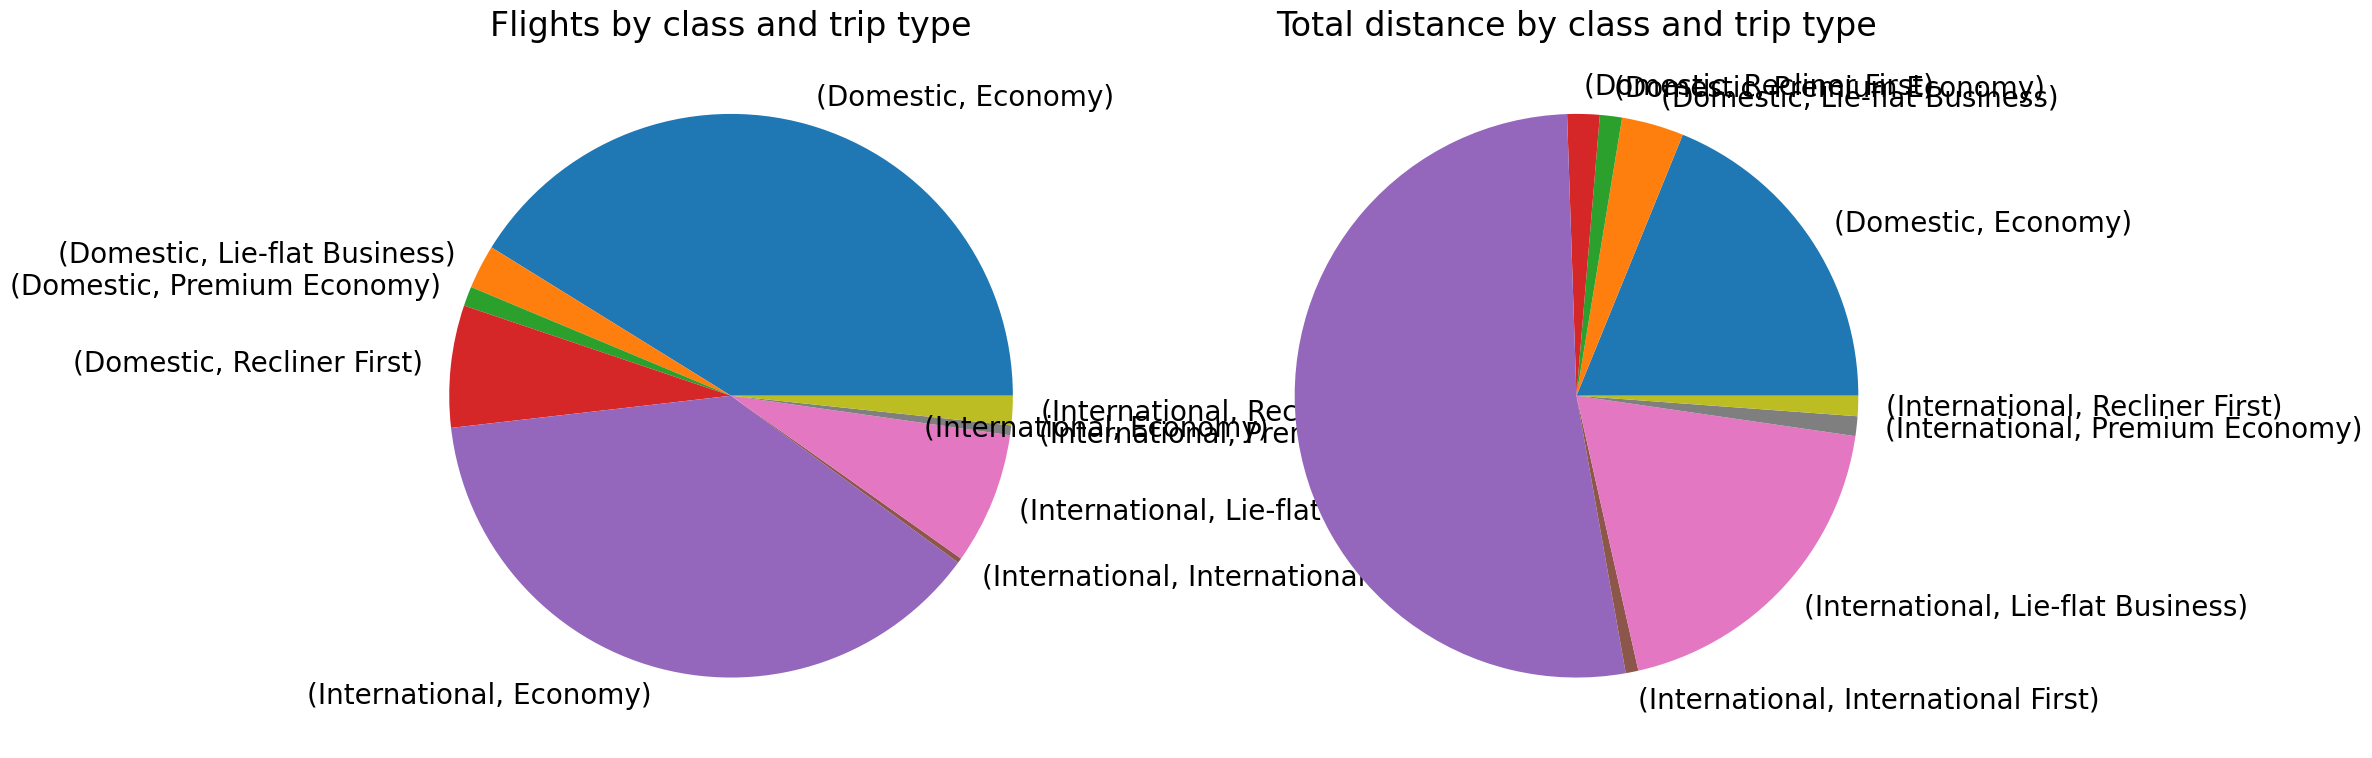

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
clas_dom_int.plot('Class', 'Flights', kind='pie', legend=False, ax=ax[0])
clas_dom_int.plot('Class', 'Distance', kind='pie', legend=False, ax=ax[1])
ax[0].set_title('Flights by class and trip type')
ax[1].set_title('Total distance by class and trip type')
ax[0].set_ylabel('')
ax[1].set_ylabel('')
plt.savefig(ROOT_DIR + 'figures/class_and_type.jpg', bbox_inches='tight')

# DEP, ARR TIMES, DELAYS

Early arrivals: 228 66%
On time arrivals (within 15 min): 56 16%
Late arrivals: 47 14%
Really late arrivals (1+hour): 12 3%


Scheduled Dep Time (Local) Scheduled Arr Time (Local)  \
0        2020-08-28 23:45:00        2020-08-29 06:51:00   
1        2018-06-02 21:05:00        2018-06-02 23:20:00   
2        2022-08-04 20:30:00        2022-08-04 23:41:00   
3        2017-03-11 12:00:00        2017-03-12 15:00:00   
4        2021-06-04 15:10:00        2021-06-04 16:21:00   
5        2025-01-07 17:00:00        2025-01-07 18:40:00   
6        2020-02-19 06:46:00        2020-02-19 08:25:00   
7        2024-09-09 12:10:00        2024-09-09 14:35:00   
8        2019-12-18 20:30:00        2019-12-19 18:00:00   
9        2024-07-11 18:05:00        2024-07-11 21:39:00   

  Actual Dep Time (Local) Actual Arr Time (Local) Actual Duration  \
0     2020-08-29 04:15:00     2020-08-29 10:43:00 0 days 04:28:00   
1     2018-06-03 01:02:00     2018-06-03 03:00:00 0 days 01:58:00   
2     2022-08-05 00:33:00     2022-08-05 02:29:00 0 days 04:56:00   
3     2017-03-11 15:44:00     2017-03-12 17:28:00 0 days 12:44:00   
4     2021-06-04 18:00:00     2021-06-04 18:47:00 0 days 00:47:00   
5     2025-01-07 18:58:00     2025-01-07 20:09:00 0 days 01:11:00   
6     2020-02-19 08:35:00     2020-02-19 09:51:00 0 days 01:16:00   
7     2024-09-09 13:41:00     2024-09-09 15:57:00 0 days 02:16:00   
8     2019-12-18 22:44:00     2019-12-19 19:17:00 0 days 13:33:00   
9     2024-07-11 19:44:00     2024-07-11 22:51:00 0 days 02:07:00   

        Airline  Flight Dep Airport Arr Airport       Dep Delay  \
0        United  UA1104         ANC         DEN 0 days 04:30:00   
1        Hainan  HU7178         HGH         PEK 0 days 03:57:00   
2        United  UA1257         EWR         SFO 0 days 04:03:00   
3        United    UA89         EWR         PEK 0 days 03:44:00   
4        United  UA3433         EWR         BOS 0 days 02:50:00   
5       Vueling  VY2119         BCN         AGP 0 days 01:58:00   
6       JetBlue   B6159         BOS         PHL 0 days 01:49:00   
7  China United  KN5822         HJJ         PKX 0 days 01:31:00   
8        United  UA1122         EWR         CPT 0 days 02:14:00   
9       Westjet  WS1523         SFO         YYC 0 days 01:39:00   

        Arr Delay  
0 0 days 03:52:00  
1 0 days 03:40:00  
2 0 days 02:48:00  
3 0 days 02:28:00  
4 0 days 02:26:00  
5 0 days 01:29:00  
6 0 days 01:26:00  
7 0 days 01:22:00  
8 0 days 01:17:00  
9 0 days 01:12:00

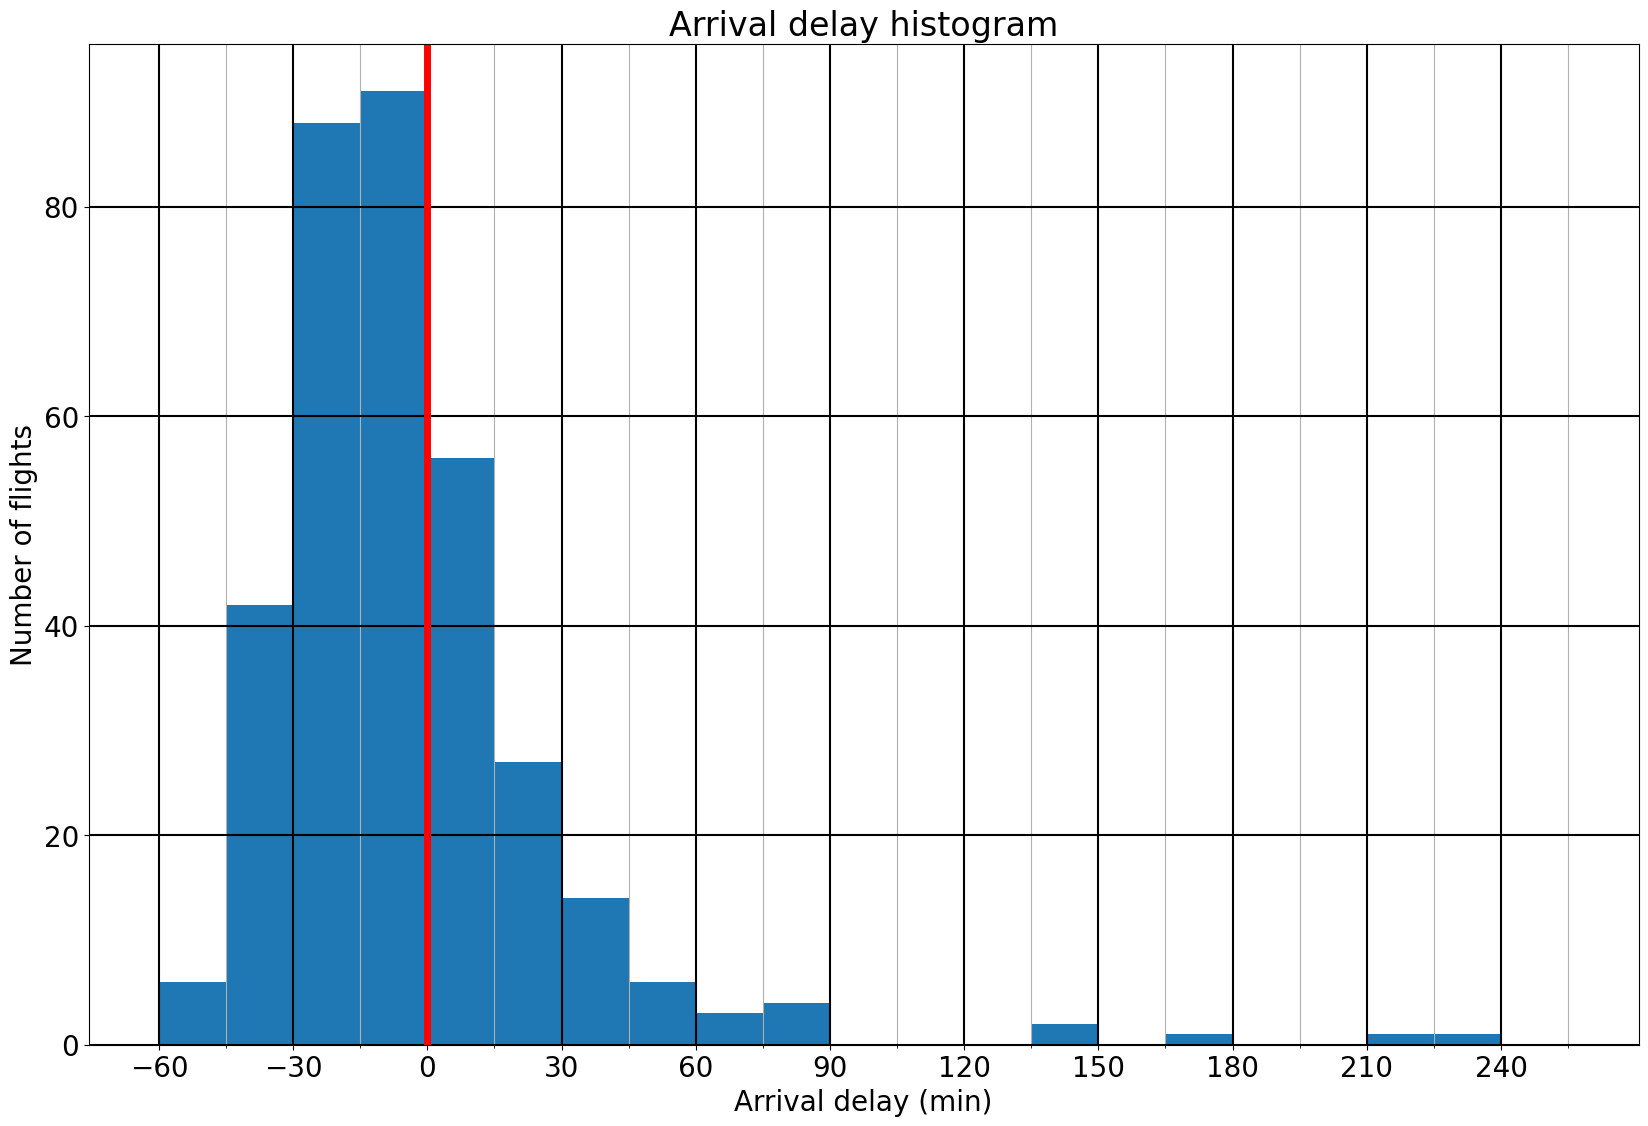

In [85]:
# ARRIVAL DEAYS
delay_cols = ['Scheduled Dep Time (Local)', 'Scheduled Arr Time (Local)', 'Actual Dep Time (Local)', 'Actual Arr Time (Local)', 'Actual Duration', 'Airline', 'Flight', 'Dep Airport', 'Arr Airport', 'Dep Delay', 'Arr Delay']

early_arrivals = past_df[past_df['Arr Delay (min)'] < 0].shape[0]
on_time_arrivals = past_df[(past_df['Arr Delay (min)'] >= 0) & (past_df['Arr Delay (min)'] < 15)].shape[0]
late_arrivals = past_df[(past_df['Arr Delay (min)'] >= 15) & (past_df['Arr Delay (min)'] < 60)].shape[0]
really_late_arrivals = past_df[past_df['Arr Delay (min)'] >= 60].shape[0]

print('Early arrivals:', early_arrivals, str(round(100*early_arrivals/NUM_FLIGHTS_PAST))+'%')
print('On time arrivals (within 15 min):', on_time_arrivals, str(round(100*on_time_arrivals/NUM_FLIGHTS_PAST))+'%')
print('Late arrivals:', late_arrivals, str(round(100*late_arrivals/NUM_FLIGHTS_PAST))+'%')
print('Really late arrivals (1+hour):', really_late_arrivals, str(round(100*really_late_arrivals/NUM_FLIGHTS_PAST))+'%')

bins = list(range(-60, math.ceil(past_df['Arr Delay (min)'].max()/30)*30+30, 15))
fig, ax = plt.subplots(figsize=(20,13))
ax.hist(past_df['Arr Delay (min)'], bins=bins)
ax.set_xticks(bins, minor=True)
ax.set_xticks([b for i, b in enumerate(bins) if b%2 == 0])
ax.grid(which='major', linewidth=1.5, color='black')
ax.grid(which='minor', axis='both')
ax.set_xlabel('Arrival delay (min)')
ax.set_ylabel('Number of flights')
ax.set_title('Arrival delay histogram')
ax.axvline(0, linewidth=5, color='red')
plt.savefig(ROOT_DIR + 'figures/arrival_delay.jpg', bbox_inches='tight')


past_df.sort_values('Arr Delay (min)', ascending=False).head(10).reset_index()[delay_cols]


Early departures: 5 1%
On time departures (within 15 min): 118 34%
Late departures: 196 57%
Really late departures (1+hour): 24 7%


Scheduled Dep Time (Local) Scheduled Arr Time (Local)  \
0        2020-08-28 23:45:00        2020-08-29 06:51:00   
1        2022-08-04 20:30:00        2022-08-04 23:41:00   
2        2018-06-02 21:05:00        2018-06-02 23:20:00   
3        2017-03-11 12:00:00        2017-03-12 15:00:00   
4        2021-06-04 15:10:00        2021-06-04 16:21:00   
5        2022-12-11 09:20:00        2022-12-12 17:30:00   
6        2019-12-18 20:30:00        2019-12-19 18:00:00   
7        2018-04-02 15:30:00        2018-04-02 17:35:00   
8        2025-01-07 17:00:00        2025-01-07 18:40:00   
9        2020-02-19 06:46:00        2020-02-19 08:25:00   

  Actual Dep Time (Local) Actual Arr Time (Local) Actual Duration  \
0     2020-08-29 04:15:00     2020-08-29 10:43:00 0 days 04:28:00   
1     2022-08-05 00:33:00     2022-08-05 02:29:00 0 days 04:56:00   
2     2018-06-03 01:02:00     2018-06-03 03:00:00 0 days 01:58:00   
3     2017-03-11 15:44:00     2017-03-12 17:28:00 0 days 12:44:00   
4     2021-06-04 18:00:00     2021-06-04 18:47:00 0 days 00:47:00   
5     2022-12-11 11:46:00     2022-12-12 18:28:00 0 days 07:42:00   
6     2019-12-18 22:44:00     2019-12-19 19:17:00 0 days 13:33:00   
7     2018-04-02 17:31:00     2018-04-02 18:35:00 0 days 05:04:00   
8     2025-01-07 18:58:00     2025-01-07 20:09:00 0 days 01:11:00   
9     2020-02-19 08:35:00     2020-02-19 09:51:00 0 days 01:16:00   

           Airline  Flight Dep Airport Arr Airport       Dep Delay  \
0           United  UA1104         ANC         DEN 0 days 04:30:00   
1           United  UA1257         EWR         SFO 0 days 04:03:00   
2           Hainan  HU7178         HGH         PEK 0 days 03:57:00   
3           United    UA89         EWR         PEK 0 days 03:44:00   
4           United  UA3433         EWR         BOS 0 days 02:50:00   
5  Air New Zealand     NZ9         HNL         AKL 0 days 02:26:00   
6           United  UA1122         EWR         CPT 0 days 02:14:00   
7              Wow   WW125         KEF         BOS 0 days 02:01:00   
8          Vueling  VY2119         BCN         AGP 0 days 01:58:00   
9          JetBlue   B6159         BOS         PHL 0 days 01:49:00   

        Arr Delay  
0 0 days 03:52:00  
1 0 days 02:48:00  
2 0 days 03:40:00  
3 0 days 02:28:00  
4 0 days 02:26:00  
5 0 days 00:58:00  
6 0 days 01:17:00  
7 0 days 01:00:00  
8 0 days 01:29:00  
9 0 days 01:26:00

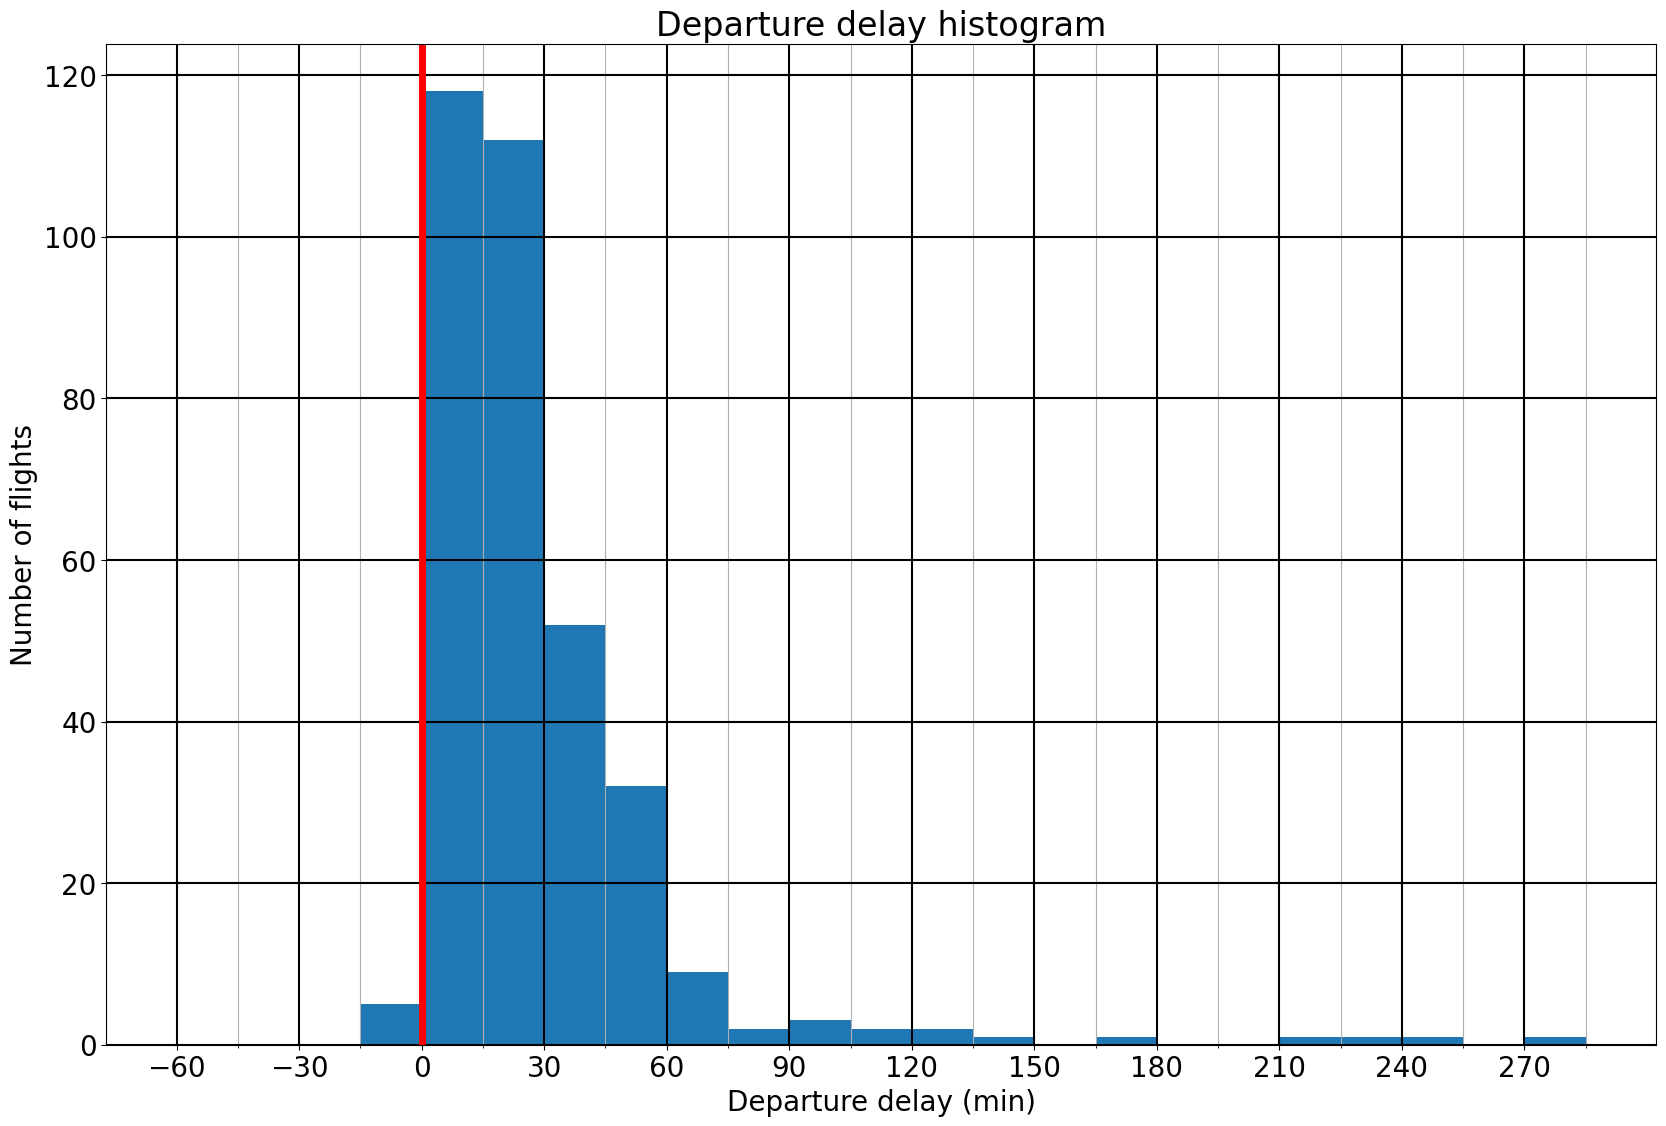

In [86]:
# DEPARTURE DELAYS

early_departures = past_df[past_df['Dep Delay (min)'] < 0].shape[0]
on_time_departures = past_df[(past_df['Dep Delay (min)'] >= 0) & (past_df['Dep Delay (min)'] < 15)].shape[0]
late_departures = past_df[(past_df['Dep Delay (min)'] >= 15) & (past_df['Dep Delay (min)'] < 60)].shape[0]
really_late_departures = past_df[past_df['Dep Delay (min)'] >= 60].shape[0]


print('Early departures:', early_departures, str(round(100*early_departures/NUM_FLIGHTS_PAST))+'%')
print('On time departures (within 15 min):', on_time_departures, str(round(100*on_time_departures/NUM_FLIGHTS_PAST))+'%')
print('Late departures:', late_departures, str(round(100*late_departures/NUM_FLIGHTS_PAST))+'%')
print('Really late departures (1+hour):', really_late_departures, str(round(100*really_late_departures/NUM_FLIGHTS_PAST))+'%')

bins = list(range(-60, math.ceil(past_df['Dep Delay (min)'].max()/30)*30+30, 15))
fig, ax = plt.subplots(figsize=(20,13))
ax.hist(past_df['Dep Delay (min)'], bins=bins)
ax.set_xticks(bins, minor=True)
ax.set_xticks([b for i, b in enumerate(bins) if b%2 == 0])
ax.grid(which='major', linewidth=1.5, color='black')
ax.grid(which='minor', axis='both')
ax.set_xlabel('Departure delay (min)')
ax.set_ylabel('Number of flights')
ax.set_title('Departure delay histogram')
ax.axvline(0, linewidth=5, color='red')
plt.savefig(ROOT_DIR + 'figures/departure_delay.jpg', bbox_inches='tight')

past_df.sort_values('Dep Delay (min)', ascending=False).head(10).reset_index()[delay_cols]


In [87]:
# Earliest arriving flights
delay_cols = ['Scheduled Dep Time (Local)', 'Scheduled Arr Time (Local)', 'Actual Dep Time (Local)', 'Actual Arr Time (Local)', 'Actual Duration', 'Airline', 'Flight', 'Dep Airport', 'Arr Airport', 'Dep Delay (min)', 'Arr Delay (min)']
past_df.sort_values('Arr Delay (min)', ascending=True).head(10).reset_index()[delay_cols]


Scheduled Dep Time (Local) Scheduled Arr Time (Local)  \
0        2024-05-03 17:00:00        2024-05-03 10:35:00   
1        2017-06-28 12:30:00        2017-06-28 13:35:00   
2        2017-12-20 12:00:00        2017-12-21 15:00:00   
3        2021-11-27 09:55:00        2021-11-27 14:55:00   
4        2023-07-11 16:50:00        2023-07-11 11:15:00   
5        2020-01-19 16:55:00        2020-01-19 19:10:00   
6        2023-01-20 08:35:00        2023-01-20 12:02:00   
7        2018-11-23 10:09:00        2018-11-23 14:45:00   
8        2025-04-23 23:20:00        2025-04-24 08:12:00   
9        2016-01-02 18:25:00        2016-01-02 19:05:00   

  Actual Dep Time (Local) Actual Arr Time (Local) Actual Duration  \
0     2024-05-03 17:10:00     2024-05-03 09:32:00 0 days 08:22:00   
1     2017-06-28 12:30:00     2017-06-28 12:40:00 0 days 01:10:00   
2     2017-12-20 12:15:00     2017-12-21 14:09:00 0 days 12:54:00   
3     2021-11-27 10:34:00     2021-11-27 14:05:00 0 days 11:31:00   
4     2023-07-11 17:00:00     2023-07-11 10:26:00 0 days 09:26:00   
5     2020-01-19 16:55:00     2020-01-19 18:23:00 0 days 01:28:00   
6     2023-01-20 08:41:00     2023-01-20 11:15:00 0 days 05:34:00   
7     2018-11-23 10:19:00     2018-11-23 14:00:00 0 days 02:41:00   
8     2025-04-23 23:30:00     2025-04-24 07:28:00 0 days 04:58:00   
9     2016-01-02 18:48:00     2016-01-02 18:23:00 0 days 12:35:00   

          Airline  Flight Dep Airport Arr Airport  Dep Delay (min)  \
0             ANA     NH8         NRT         SFO             10.0   
1  China Southern   CZ318         GMP         PEK              0.0   
2          United    UA89         EWR         PEK             15.0   
3             TAP   TP237         LIS         SFO             39.0   
4          United    UA34         KIX         SFO             10.0   
5       Air China  CA1611         PEK         HRB              0.0   
6          United   UA731         PHL         SFO              6.0   
7          United  UA5481         ORD         NAS             10.0   
8          United  UA1665         SFO         BOS             10.0   
9          United   UA808         PEK         IAD             23.0   

   Arr Delay (min)  
0            -63.0  
1            -55.0  
2            -51.0  
3            -50.0  
4            -49.0  
5            -47.0  
6            -47.0  
7            -45.0  
8            -44.0  
9            -42.0

In [88]:
# Earliest departing flights
past_df.sort_values('Dep Delay (min)', ascending=True).head(10).reset_index()[delay_cols]




Scheduled Dep Time (Local) Scheduled Arr Time (Local)  \
0        2024-03-10 17:40:00        2024-03-10 19:00:00   
1        2020-03-15 12:47:00        2020-03-15 15:00:00   
2        2023-12-16 19:55:00        2023-12-16 21:00:00   
3        2019-11-28 08:20:00        2019-11-28 20:50:00   
4        2024-03-10 20:30:00        2024-03-11 00:15:00   
5        2019-05-30 07:55:00        2019-05-30 11:40:00   
6        2017-06-28 12:30:00        2017-06-28 13:35:00   
7        2021-04-29 15:30:00        2021-04-29 19:50:00   
8        2016-03-16 09:35:00        2016-03-16 12:40:00   
9        2016-03-24 20:50:00        2016-03-24 22:50:00   

  Actual Dep Time (Local) Actual Arr Time (Local) Actual Duration  \
0     2024-03-10 17:26:00     2024-03-10 18:34:00 0 days 01:08:00   
1     2020-03-15 12:39:00     2020-03-15 14:31:00 0 days 01:52:00   
2     2023-12-16 19:48:00     2023-12-16 20:43:00 0 days 00:55:00   
3     2019-11-28 08:14:00     2019-11-28 20:40:00 0 days 07:26:00   
4     2024-03-10 20:29:00     2024-03-10 23:54:00 0 days 01:25:00   
5     2019-05-30 07:55:00     2019-05-30 11:16:00 0 days 03:21:00   
6     2017-06-28 12:30:00     2017-06-28 12:40:00 0 days 01:10:00   
7     2021-04-29 15:30:00     2021-04-29 19:36:00 0 days 04:06:00   
8     2016-03-16 09:35:00     2016-03-16 12:20:00 0 days 02:45:00   
9     2016-03-24 20:50:00     2016-03-24 22:15:00 0 days 01:25:00   

          Airline  Flight Dep Airport Arr Airport  Dep Delay (min)  \
0  China Southern  CZ6614         KJI         URC            -14.0   
1           Delta  DL2667         BOS         DTW             -8.0   
2             LOT   LO526         PRG         WAW             -7.0   
3          United   UA122         IAD         LHR             -6.0   
4  China Southern  CZ6909         URC         PKX             -1.0   
5       Air China  CA1469         PEK         LJG              0.0   
6  China Southern   CZ318         GMP         PEK              0.0   
7          United  UA1784         STT         EWR              0.0   
8          Hainan  HU7215         PEK         KWL              0.0   
9   China Eastern  MU2117         XIY         PEK              0.0   

   Arr Delay (min)  
0            -26.0  
1            -29.0  
2            -17.0  
3            -10.0  
4            -21.0  
5            -24.0  
6            -55.0  
7            -14.0  
8            -20.0  
9            -35.0

In [89]:
# Arrival delay by year
delay_by_year = past_df.groupby(past_df['Date'].dt.year)['Arr Delay (min)'].aggregate(
    count='count', 
    early_flights=lambda x: x[x<=0].count(),
    late_flights=lambda x: x[x>0].count(),
    percent_early=lambda x: 100*(x[x<=0].count()/len(x)),
    avg_gained_time=lambda x: x[x <= 0].mean(), 
    avg_lost_time=lambda x: x[x > 0].mean(), 
    avg_net_time_lost='mean',
    total_net_time_lost=sum).fillna(0).round().astype(int, errors='ignore')

delay_by_year

/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3840423199.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  delay_by_year = past_df.groupby(past_df['Date'].dt.year)['Arr Delay (min)'].aggregate(


count  early_flights  late_flights  percent_early  avg_gained_time  \
Date                                                                       
2015     11              5             6             45              -18   
2016     22             16             6             73              -21   
2017     39             28            11             72              -24   
2018     26             19             7             73              -19   
2019     32             24             8             75              -16   
2020     30             22             8             73              -24   
2021     33             24             9             73              -17   
2022     35             24            11             69              -18   
2023     44             35             9             80              -21   
2024     46             26            20             57              -18   
2025     25             11            14             44              -13   

      avg_lost_time  avg_net_time_lost  total_net_time_lost  
Date                                                         
2015             22                  4                   40  
2016              5                -14                 -308  
2017             36                 -7                 -284  
2018             59                  2                   55  
2019             27                 -6                 -178  
2020             47                 -5                 -159  
2021             29                 -5                 -157  
2022             37                 -1                  -34  
2023             20                -13                 -566  
2024             23                  0                   -1  
2025             21                  6                  157

In [90]:
# Arrival delay by airline
top_airlines = past_df.groupby('Airline').agg({'Date': 'count'})
top_airlines = top_airlines[top_airlines['Date'] >= 8].index.tolist()
filtered_rows = past_df[past_df['Airline'].isin(top_airlines)]
arrival_delay_by_airline = filtered_rows.groupby(filtered_rows['Airline'])['Arr Delay (min)'].aggregate(
    count='count', 
    early_flights=lambda x: x[x<=0].count(),
    late_flights=lambda x: x[x>0].count(),
    percent_early=lambda x: 100*(x[x<=0].count()/len(x)),
    avg_gained_time=lambda x: x[x <= 0].mean(), 
    avg_lost_time=lambda x: x[x > 0].mean(), 
    avg_net_time_lost='mean').sort_values('percent_early', ascending=False)

delay_by_airline = arrival_delay_by_airline.fillna(0).round().astype(int, errors='ignore')

delay_by_airline

count  early_flights  late_flights  percent_early  \
Airline                                                             
Delta               8              8             0            100   
United            158            124            34             78   
JetBlue             9              7             2             78   
Air China          21             14             7             67   
Lufthansa          10              6             4             60   
Hainan             14              8             6             57   
China Southern     11              6             5             55   
TAP                 8              4             4             50   
Ryanair            10              3             7             30   

                avg_gained_time  avg_lost_time  avg_net_time_lost  
Airline                                                            
Delta                       -24              0                -24  
United                      -22             34                -10  
JetBlue                     -16             44                 -3  
Air China                   -18             18                 -6  
Lufthansa                   -14             18                 -1  
Hainan                      -24             66                 14  
China Southern              -19             27                  2  
TAP                         -19             20                  0  
Ryanair                     -10             15                  8

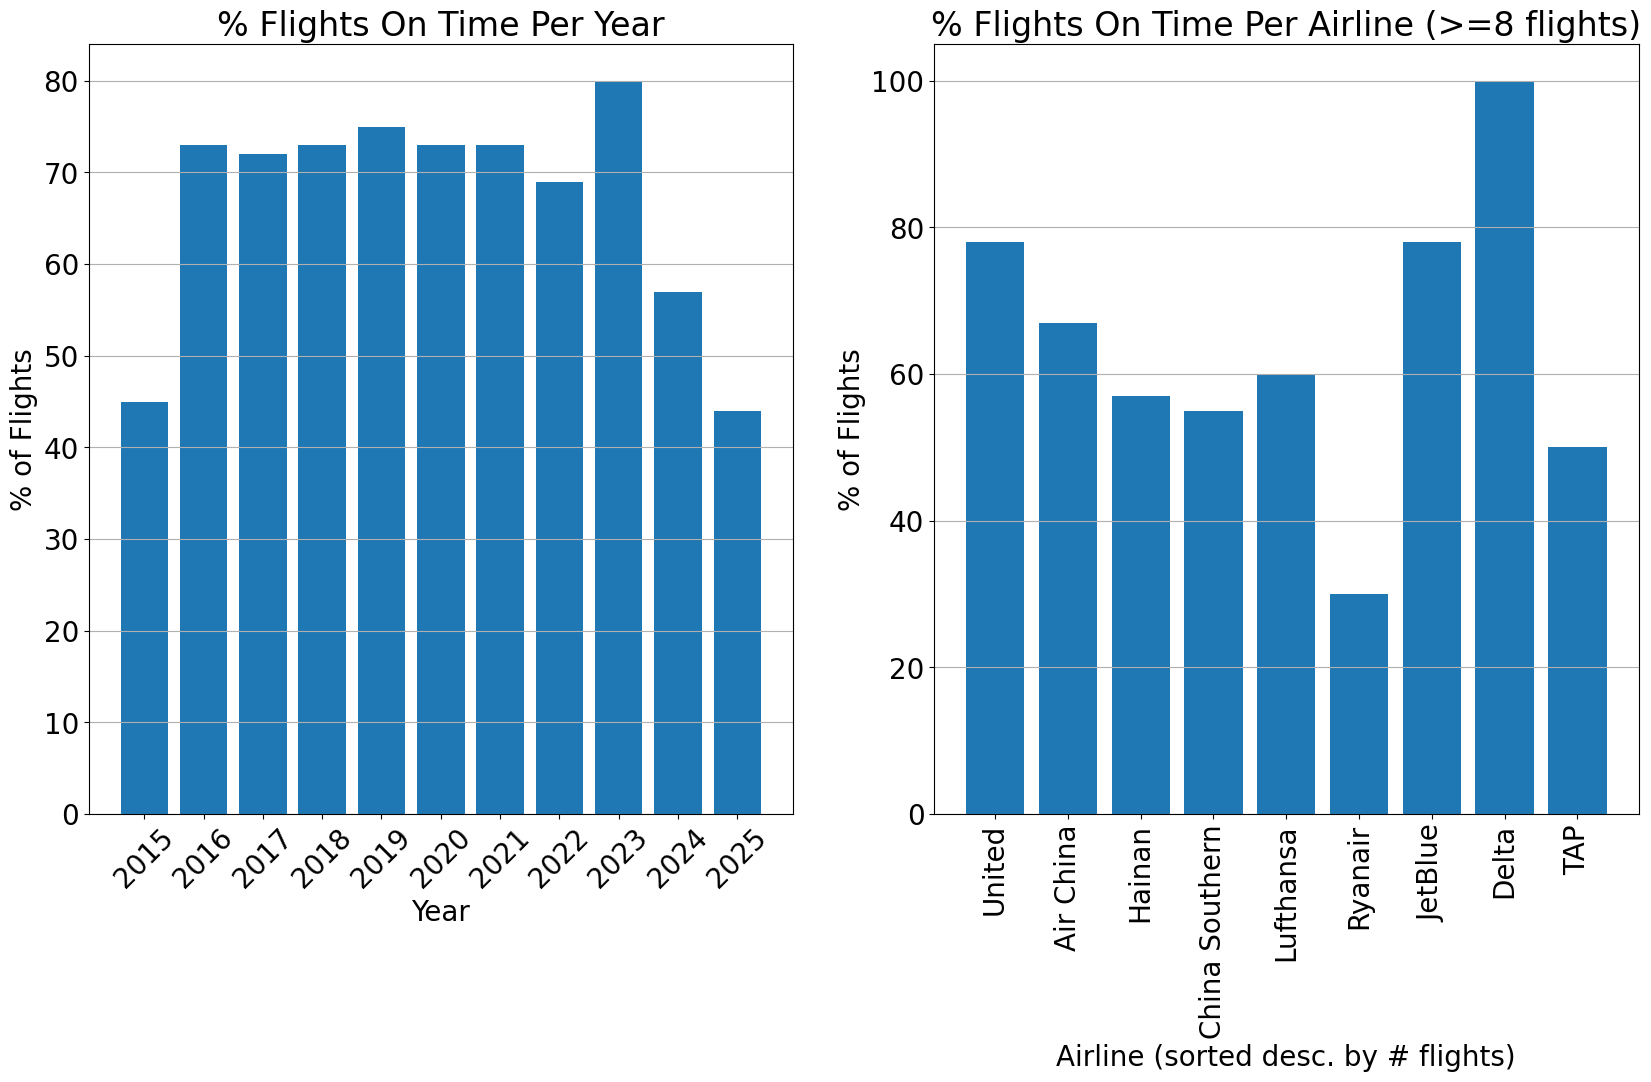

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].bar(delay_by_year.index, delay_by_year['percent_early'])
ax[0].grid(axis='y')
ax[0].set_title('% Flights On Time Per Year')
ax[0].set_ylabel('% of Flights')
ax[0].set_xticks(delay_by_year.index)
ax[0].set_xlabel('Year')
ax[0].tick_params(axis='x', rotation=45)
ax[1].bar(delay_by_airline.sort_values(by='count', ascending=False).index, delay_by_airline.sort_values(by='count', ascending=False)['percent_early'])
ax[1].grid(axis='y')
ax[1].set_title('% Flights On Time Per Airline (>=8 flights)')
ax[1].set_ylabel('% of Flights')
ax[1].set_xlabel('Airline (sorted desc. by # flights)')
ax[1].tick_params(axis='x', rotation=90)
plt.savefig(ROOT_DIR + 'figures/delays_bar.jpg', bbox_inches='tight')

Scheduled Dep Time (Local) Scheduled Arr Time (Local)  \
190        2021-11-27 09:55:00        2021-11-27 14:55:00   
223        2022-12-11 09:20:00        2022-12-12 17:30:00   
218        2022-11-10 10:40:00        2022-11-11 20:15:00   
22         2016-07-03 16:10:00        2016-07-03 16:15:00   
36         2017-03-11 12:00:00        2017-03-12 15:00:00   
211        2022-08-04 20:30:00        2022-08-04 23:41:00   
269        2023-12-17 13:10:00        2023-12-18 06:35:00   
296        2024-05-03 17:00:00        2024-05-03 10:35:00   
70         2017-12-20 12:00:00        2017-12-21 15:00:00   
11         2016-01-02 18:25:00        2016-01-02 19:05:00   

    Actual Dep Time (Local) Actual Arr Time (Local) Scheduled Duration  \
190     2021-11-27 10:34:00     2021-11-27 14:05:00    0 days 13:00:00   
223     2022-12-11 11:46:00     2022-12-12 18:28:00    0 days 09:10:00   
218     2022-11-10 11:30:00     2022-11-11 19:39:00    0 days 17:35:00   
22      2016-07-03 17:01:00     2016-07-03 15:42:00    0 days 13:05:00   
36      2017-03-11 15:44:00     2017-03-12 17:28:00    0 days 14:00:00   
211     2022-08-05 00:33:00     2022-08-05 02:29:00    0 days 06:11:00   
269     2023-12-17 14:33:00     2023-12-18 06:44:00    0 days 10:25:00   
296     2024-05-03 17:10:00     2024-05-03 09:32:00    0 days 09:35:00   
70      2017-12-20 12:15:00     2017-12-21 14:09:00    0 days 14:00:00   
11      2016-01-02 18:48:00     2016-01-02 18:23:00    0 days 13:40:00   

    Actual Duration          Airline  Flight Dep Airport Arr Airport  \
190 0 days 11:31:00              TAP   TP237         LIS         SFO   
223 0 days 07:42:00  Air New Zealand     NZ9         HNL         AKL   
218 0 days 16:09:00           United    UA29         SFO         SIN   
22  0 days 11:41:00           United   UA850         PEK         ORD   
36  0 days 12:44:00           United    UA89         EWR         PEK   
211 0 days 04:56:00           United  UA1257         EWR         SFO   
269 0 days 09:11:00              LOT    LO91         WAW         PEK   
296 0 days 08:22:00              ANA     NH8         NRT         SFO   
70  0 days 12:54:00           United    UA89         EWR         PEK   
11  0 days 12:35:00           United   UA808         PEK         IAD   

     Dep Delay (min)  Arr Delay (min)  Minutes Made Up  
190             39.0            -50.0             89.0  
223            146.0             58.0             88.0  
218             50.0            -36.0             86.0  
22              51.0            -33.0             84.0  
36             224.0            148.0             76.0  
211            243.0            168.0             75.0  
269             83.0              9.0             74.0  
296             10.0            -63.0             73.0  
70              15.0            -51.0             66.0  
11              23.0            -42.0             65.0

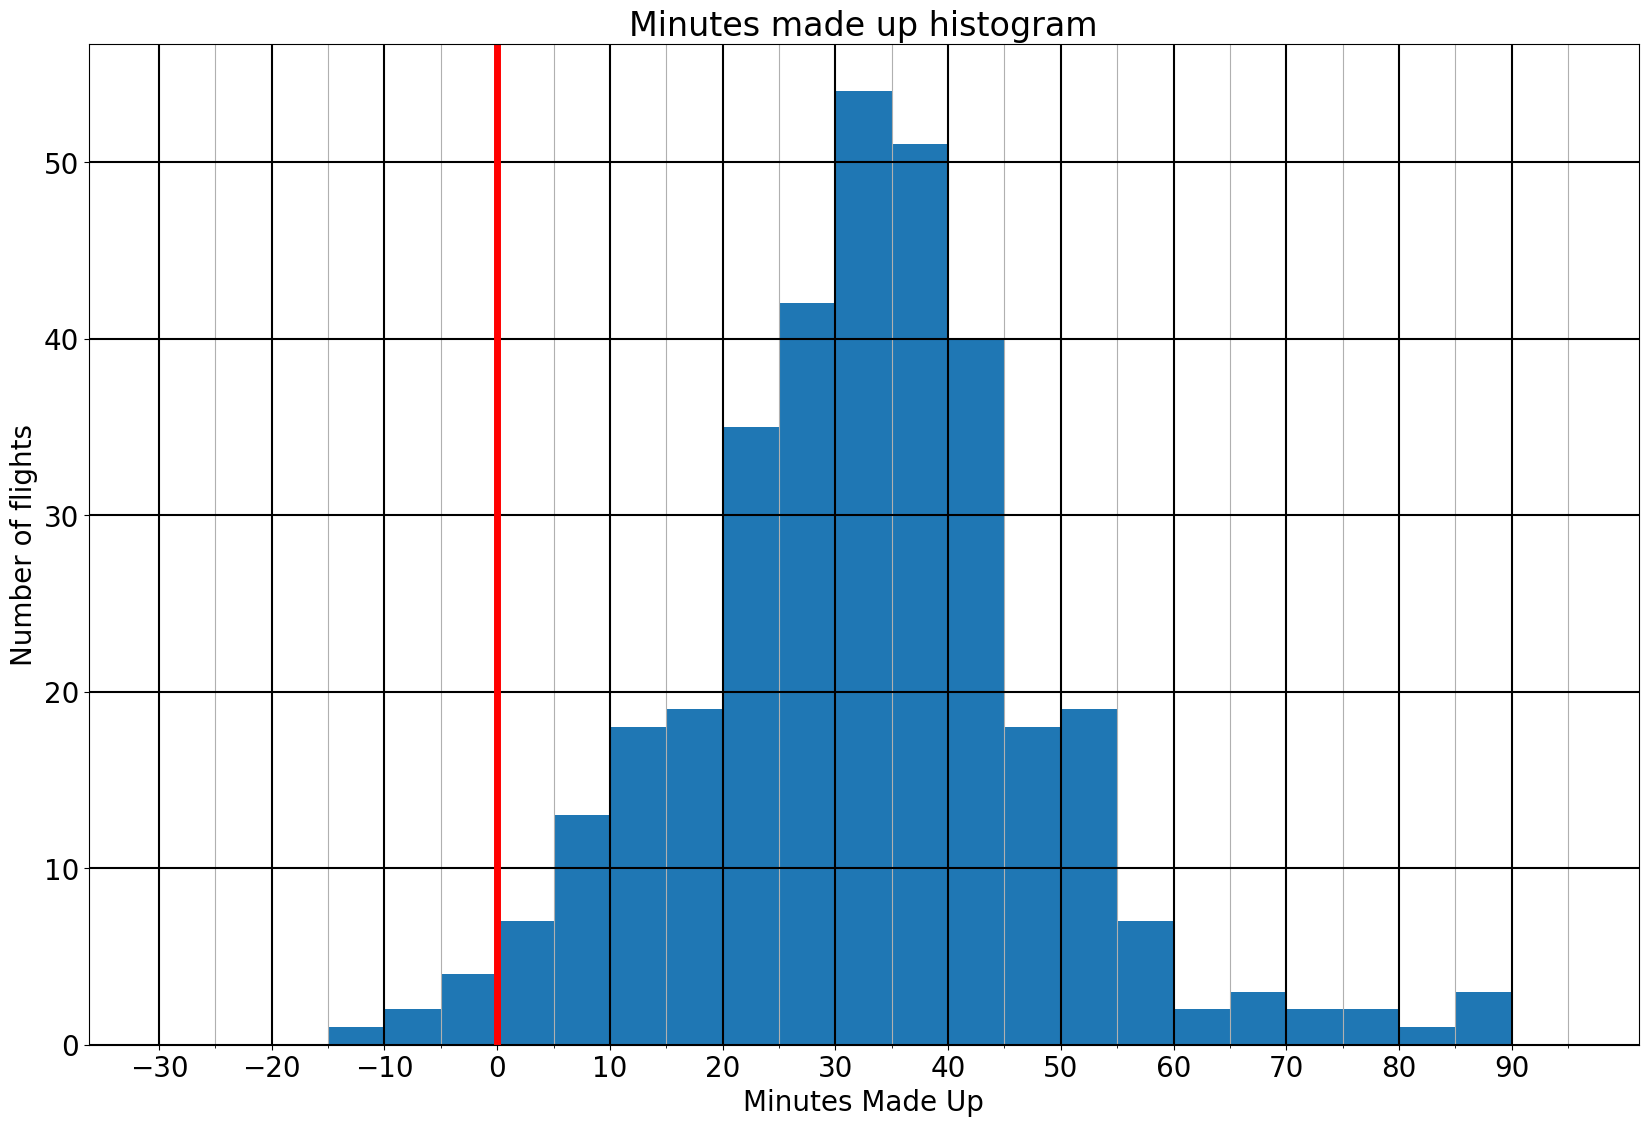

In [92]:
# Top flights in making up time
delay_cols = ['Scheduled Dep Time (Local)', 'Scheduled Arr Time (Local)', 'Actual Dep Time (Local)', 'Actual Arr Time (Local)', 'Scheduled Duration', 'Actual Duration', 'Airline', 'Flight', 'Dep Airport', 'Arr Airport', 'Dep Delay (min)', 'Arr Delay (min)', 'Minutes Made Up']

bins = list(range(-30, math.ceil(past_df['Minutes Made Up'].max()/10)*10+10, 5))
fig, ax = plt.subplots(figsize=(20,13))
ax.hist(past_df['Minutes Made Up'], bins=bins)
ax.set_xticks(bins, minor=True)
ax.set_xticks([b for i, b in enumerate(bins) if b%2 == 0])
ax.grid(which='major', linewidth=1.5, color='black')
ax.grid(which='minor', axis='both')
ax.set_xlabel('Minutes Made Up')
ax.set_ylabel('Number of flights')
ax.set_title('Minutes made up histogram')
ax.axvline(0, linewidth=5, color='red')
plt.savefig(ROOT_DIR + 'figures/minutes_made_up.jpg', bbox_inches='tight')

past_df.sort_values('Minutes Made Up', ascending=False).head(10)[delay_cols]


In [93]:
# Making up time by year

In [94]:
# Making up time by airline

# DEPARTURE/ARRIVAL TIMES

Morning flights (5a-12p): 118, 33%
Afternoon flights (12p-6p): 119, 33%
Evening flights (6p-11p): 96, 27%
Late nights flights (11p-5a): 24, 7%


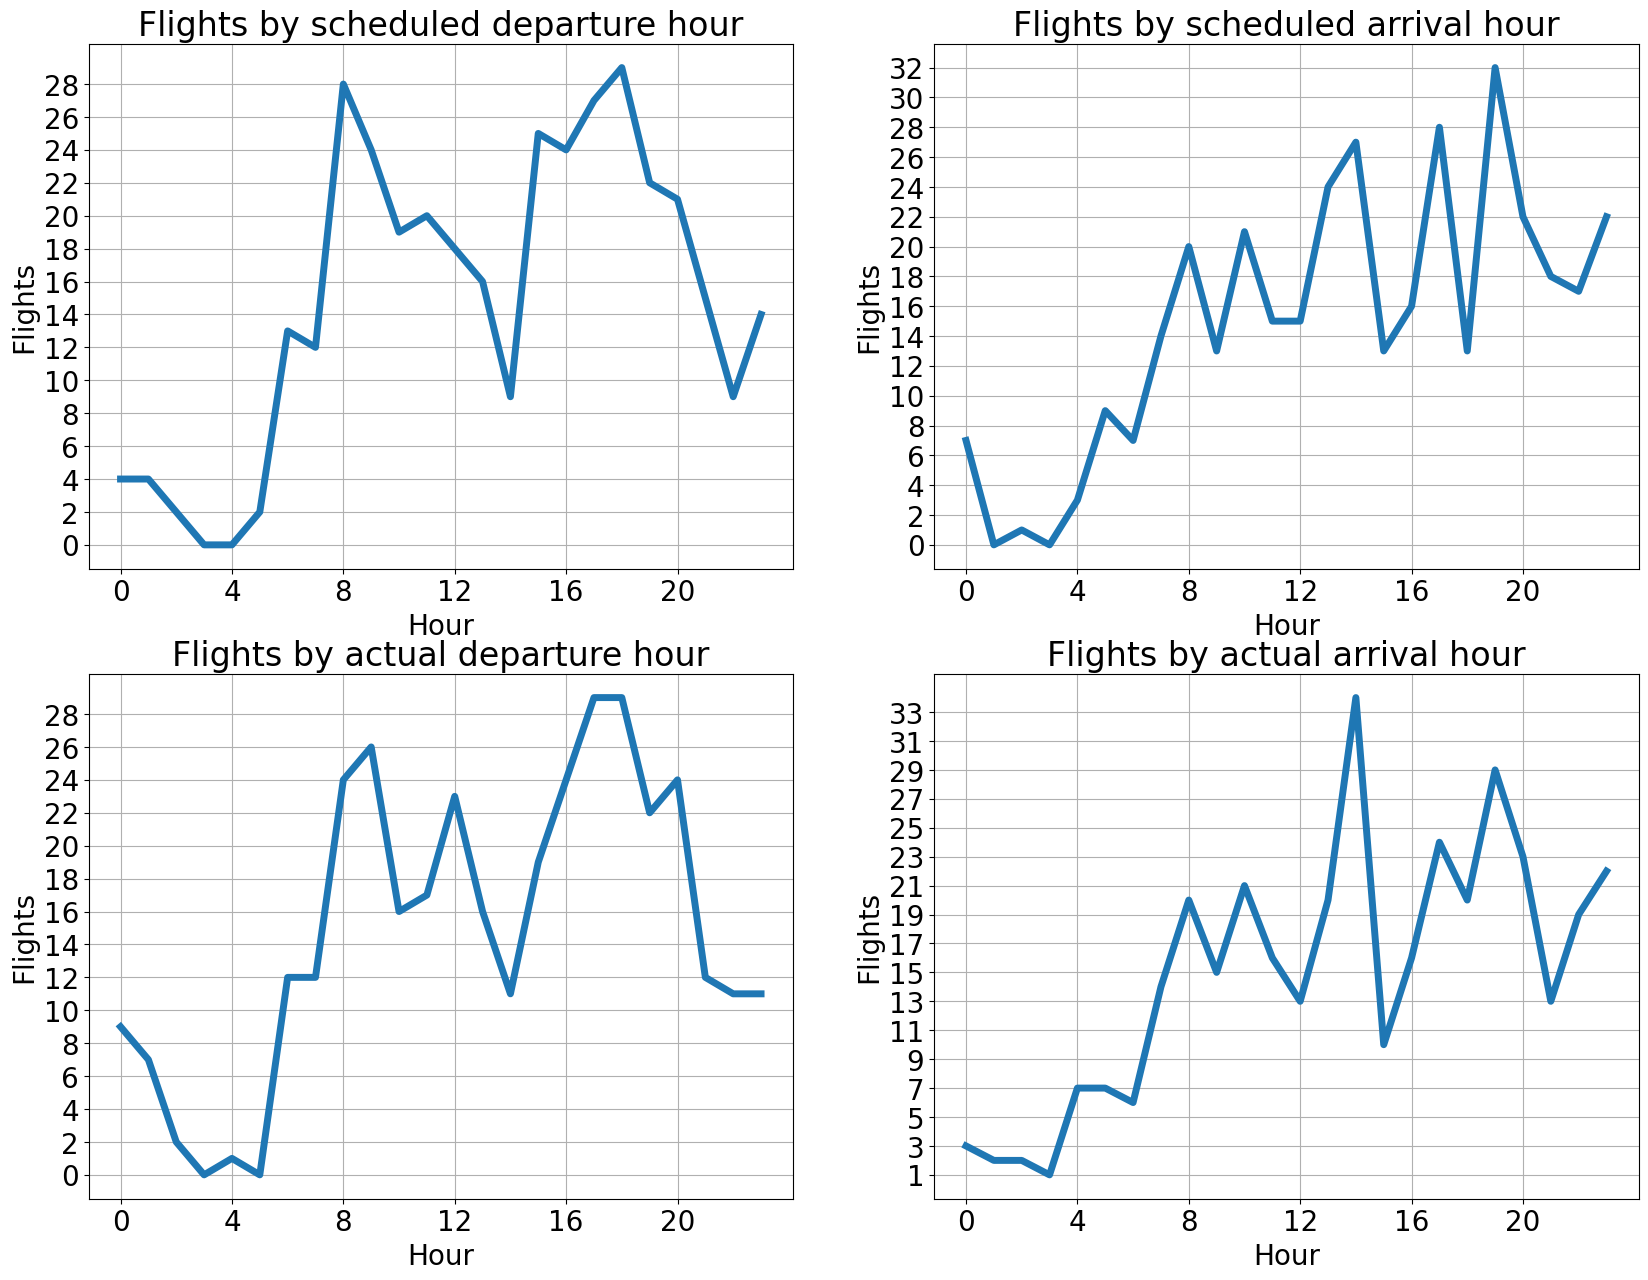

In [95]:
morning_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 5) & (df['Scheduled Dep Time (Local)'].dt.hour <= 11)].shape[0]
afternoon_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 12) & (df['Scheduled Dep Time (Local)'].dt.hour <= 17)].shape[0]
evening_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 18) & (df['Scheduled Dep Time (Local)'].dt.hour <= 22)].shape[0]
late_night_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 23) | (df['Scheduled Dep Time (Local)'].dt.hour <= 4)].shape[0]

print('Morning flights (5a-12p): ' + str(morning_flights) + ', ' + str(int(round(100*morning_flights/NUM_FLIGHTS))) + '%')
print('Afternoon flights (12p-6p): ' + str(afternoon_flights) + ', ' + str(int(round(100*afternoon_flights/NUM_FLIGHTS))) + '%')
print('Evening flights (6p-11p): ' + str(evening_flights) + ', ' + str(int(round(100*evening_flights/NUM_FLIGHTS))) + '%')
print('Late nights flights (11p-5a): ' + str(late_night_flights) + ', ' + str(int(round(100*late_night_flights/NUM_FLIGHTS))) + '%')

df['Scheduled dep hour'] = df['Scheduled Dep Time (Local)'].dt.hour
df['Scheduled arr hour'] = df['Scheduled Arr Time (Local)'].dt.hour
df['Actual dep hour'] = df['Actual Dep Time (Local)'].dt.hour
df['Actual arr hour'] = df['Actual Arr Time (Local)'].dt.hour

scheduled_dep_hour = df.groupby('Scheduled dep hour') .agg({'Date': 'count'}).reset_index().rename(columns={'Scheduled dep hour': 'Hour', 'Date': 'Count'})
for h in set(range(0, 24)) - set(scheduled_dep_hour['Hour']):
    scheduled_dep_hour = pd.concat([scheduled_dep_hour, pd.DataFrame({'Hour': h, 'Count': 0}, index=[0])])
scheduled_dep_hour = scheduled_dep_hour.sort_values(by='Hour')

scheduled_arr_hour = df.groupby('Scheduled arr hour').agg({'Date': 'count'}).reset_index().rename(columns={'Scheduled arr hour': 'Hour', 'Date': 'Count'})
for h in set(range(0, 24)) - set(scheduled_arr_hour['Hour']):
    scheduled_arr_hour = pd.concat([scheduled_arr_hour, pd.DataFrame({'Hour': h, 'Count': 0}, index=[0])])
scheduled_arr_hour = scheduled_arr_hour.sort_values(by='Hour')

actual_dep_hour = df.groupby('Actual dep hour').agg({'Date': 'count'}).reset_index().rename(columns={'Actual dep hour': 'Hour', 'Date': 'Count'})
for h in set(range(0, 24)) - set(actual_dep_hour['Hour']):
    actual_dep_hour = pd.concat([actual_dep_hour, pd.DataFrame({'Hour': h, 'Count': 0}, index=[0])])
actual_dep_hour = actual_dep_hour.sort_values(by='Hour')

actual_arr_hour = df.groupby('Actual arr hour').agg({'Date': 'count'}).reset_index().rename(columns={'Actual arr hour': 'Hour', 'Date': 'Count'})
for h in set(range(0, 24)) - set(actual_arr_hour['Hour']):
    actual_arr_hour = pd.concat([actual_arr_hour, pd.DataFrame({'Hour': h, 'Count': 0}, index=[0])])
actual_arr_hour = actual_arr_hour.sort_values(by='Hour')

fig, ax = plt.subplots(2, 2, figsize=(20,15))
ax[0, 0].plot(scheduled_dep_hour['Hour'], scheduled_dep_hour['Count'], linewidth=5)
ax[0, 0].grid(True)
ax[0, 0].set_xticks(range(0,24,4))
ax[0, 0].set_xlabel('Hour')
ax[0, 0].set_yticks(np.arange(min(scheduled_dep_hour['Count']), max(scheduled_dep_hour['Count'])+1, 2.0))
ax[0, 0].set_ylabel('Flights')
ax[0, 0].set_title('Flights by scheduled departure hour')

ax[1, 0].plot(actual_dep_hour['Hour'], actual_dep_hour['Count'], linewidth=5)
ax[1, 0].grid(True)
ax[1, 0].set_xticks(range(0,24,4))
ax[1, 0].set_xlabel('Hour')
ax[1, 0].set_yticks(np.arange(min(actual_dep_hour['Count']), max(actual_dep_hour['Count'])+1, 2.0))
ax[1, 0].set_ylabel('Flights')
ax[1, 0].set_title('Flights by actual departure hour')

ax[0, 1].plot(scheduled_arr_hour['Hour'], scheduled_arr_hour['Count'], linewidth=5)
ax[0, 1].grid(True)
ax[0, 1].set_xticks(range(0,24,4))
ax[0, 1].set_xlabel('Hour')
ax[0, 1].set_yticks(np.arange(min(scheduled_arr_hour['Count']), max(scheduled_arr_hour['Count'])+1, 2.0))
ax[0, 1].set_ylabel('Flights')
ax[0, 1].set_title('Flights by scheduled arrival hour')

ax[1, 1].plot(actual_arr_hour['Hour'], actual_arr_hour['Count'], linewidth=5)
ax[1, 1].grid(True)
ax[1, 1].set_xticks(range(0,24,4))
ax[1, 1].set_xlabel('Hour')
ax[1, 1].set_yticks(np.arange(min(actual_arr_hour['Count']), max(actual_arr_hour['Count'])+1, 2.0))
ax[1, 1].set_ylabel('Flights')
ax[1, 1].set_title('Flights by actual arrival hour')
plt.savefig(ROOT_DIR + 'figures/by_hour.jpg', bbox_inches='tight')



# ROUTES

In [96]:
#Augment routes

def get_hist(x):
    dct = {a: x.tolist().count(a) for a in x.tolist()}
    return ';'.join([str(list(dct.keys())[i]) + ',' + str(list(dct.values())[i]) for i in range(len(dct))])


def augment_routes(df):
    route_grouped = df.groupby('Sorted Route')
    df[['Class', 'Airline', 'Flight']] = df[['Class', 'Airline', 'Flight']].fillna('Unknown')
    df['route_date_string'] = route_grouped['Date'].transform(lambda x: ';'.join(str(a) for a in x))
    df['route_class_hist'] = route_grouped['Class'].transform(get_hist)#(lambda x: str(x.tolist().count('Economy')) + ',' + str(x.tolist().count('Business')))
    df['route_airline_hist'] = route_grouped['Airline'].transform(get_hist)
    df['route_flight_string'] = route_grouped['Flight'].transform(lambda x: ';'.join(x))
    df['route_origin_hist'] = route_grouped['Dep Airport'].transform(get_hist)
    grouped = df.groupby('Sorted Route').first()[['Distance', 'Actual Duration (min)', 'Domestic/International',
                                        'route_date_string', 'route_class_hist', 'route_airline_hist', 'route_flight_string', 'route_origin_hist'
                                       ]]
    grouped['count'] = grouped['route_date_string'].apply(lambda x: len(x.split(';')))

    grouped = grouped.reset_index()
    grouped['Dep IATA'] = grouped['Sorted Route'].apply(lambda x: x.split(' ')[0])
    grouped['Arr IATA'] = grouped['Sorted Route'].apply(lambda x: x.split(' ')[1])
    grouped = grouped.merge(airports[['IATA', 'Name', 'City', 'Country', 'Lat', 'Long']], left_on='Dep IATA', right_on='IATA', how='left')
    grouped = grouped.drop(columns='IATA').rename(columns={'Name': 'Dep Name', 'City': 'Dep City', 'Country': 'Dep Country', 'Lat': 'Dep Lat', 'Long': 'Dep Long'})
    grouped = grouped.merge(airports[['IATA', 'Name', 'City', 'Country', 'Lat', 'Long']], left_on='Arr IATA', right_on='IATA', how='left')
    grouped = grouped.drop(columns='IATA').rename(columns={'Name': 'Arr Name', 'City': 'Arr City', 'Country': 'Arr Country', 'Lat': 'Arr Lat', 'Long': 'Arr Long'})

    return grouped






In [97]:
routes = df.groupby(['Dep Airport', 'Arr Airport']).agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
routes.columns = ['Count', 'Total Distance']
routes.head(15)



/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/1327263403.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  routes = df.groupby(['Dep Airport', 'Arr Airport']).agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)


Count  Total Distance
Dep Airport Arr Airport                       
BOS         EWR             14            2814
EWR         BOS             12            2412
            PEK             10           68310
SFO         BOS              7           18928
PEK         EWR              5           34155
BOS         ORD              3            2601
EWR         SFO              3            7695
SFO         LHR              3           16104
IAD         BOS              3            1239
SFO         EWR              3            7695
BOS         IAD              3            1239
PEK         SFO              3           17739
            IAD              3           20763
BOS         SFO              2            5408
SYX         PEK              2            3120

In [98]:
df['Sorted Route'] = df.apply(lambda row: str(sorted([row['Dep Airport'], row['Arr Airport']])[0]) + ' ' + str(sorted([row['Dep Airport'], row['Arr Airport']])[1]), axis=1)
routes_sorted = df.groupby('Sorted Route').agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
routes_sorted.columns = ['Count', 'Total Distance']
routes_sorted[routes_sorted['Count'] >=2].reset_index()

/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/2012449379.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  routes_sorted = df.groupby('Sorted Route').agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)


Sorted Route  Count  Total Distance
0       BOS EWR     26            5226
1       EWR PEK     15          102465
2       BOS SFO      9           24336
3       BOS IAD      6            2478
4       EWR SFO      6           15390
5       KJI URC      4            1196
6       PEK SYX      4            6240
7       BOS DEN      4            7016
8       LAS SFO      4            1656
9       BOS ORD      4            3468
10      BOS PEK      4           26948
11      LHR SFO      4           21472
12      JFK SFO      3            7758
13      BOS DTW      3            1896
14      BOS LAX      3            7833
15      SEA SFO      3            2037
16      BOS PHL      3             840
17      SFO SIN      3           25338
18      PEK PVG      3            2046
19      IAD PEK      3           20763
20      PEK SFO      3           17739
21      IAH SFO      3            4905
22      OAK SLC      2            1176
23      DEN SGU      2            1034
24      NRT PEK      2            2660
25      DXB PEK      2            7276
26      MUC SFO      2           11758
27      PEK UBN      2            1428
28      CDG SEN      2             390
29      MLA STN      2            2620
30      LIS MUC      2            2470
31      EWR LHR      2            6930
32      HKG PEK      2            2468
33      IST NAV      2             704
34      ICN PEK      2            1124
35      IAH SJO      2            3104
36      KOA SFO      2            4734
37      HRB PEK      2            1244
38      LAX SFO      2             674
39      LHR PEK      2           10160
40      LIS SFO      2           11362
41      HGH PEK      2            1426
42      GMP PEK      2            1154
43      FRA SFO      2           11398
44      FCO LIS      2            2290
45      EWR SKB      2            3498
46      CDG LHR      2             432
47      CDG NCE      2             864
48      CUZ LIM      2             728
49      PEK URC      2            3028
50      BOS PVG      2           14616
51      PVR SFO      2            3108
52      SAN SFO      2             894
53      PSP SJC      2             780
54      PEK WAW      2            8652
55      AUH PKX      2            7398
56      PKX XMN      2            2072
57      BOS CDG      2            6896
58      AUH LHR      2            6864
59      SFO SLC      2            1198
60      PHX SFO      2            1302
61      BOS KEF      2            4826
62      SFO TPA      2            4786
63      PHL SFO      2            5042
64      ANC DEN      2            4810
65      BDA JFK      2            1524
66      PEK WUX      2            1260
67      SFO YYC      2            2036
68      STN VLC      2            1714
69      SGN SIN      2            1352
70      BOS SJU      2            3348

# AIRPORTS

In [99]:
# Augment airports

def augment_airports(df):
    df['Year'] = df['Date'].dt.year

    dep_grouped = df.groupby('Dep Airport')
    df['dep_dest_hist'] = dep_grouped['Arr Airport'].transform(get_hist)
    df['dep_count'] = dep_grouped['Date'].transform(lambda v: v.shape[0])
    df['dep_first'] = dep_grouped['Date'].transform(lambda v: min(v))
    df['dep_last'] = dep_grouped['Date'].transform(lambda v: max(v))
    df['dep_airline_hist'] = dep_grouped['Airline'].transform(get_hist)
    df['dep_intdom_hist'] = dep_grouped['Domestic/International'].transform(get_hist)
    df['dep_year_hist'] = dep_grouped['Year'].transform(get_hist)

    arr_grouped = df.groupby('Arr Airport')
    df['arr_dest_hist'] = arr_grouped['Dep Airport'].transform(get_hist)
    df['arr_count'] = arr_grouped['Date'].transform(lambda v: v.shape[0])
    df['arr_first'] = arr_grouped['Date'].transform(lambda v: min(v))
    df['arr_last'] = arr_grouped['Date'].transform(lambda v: max(v))
    df['arr_conn_count'] = arr_grouped['Arr Connect'].transform(lambda v: int(v.sum())).astype('int')
    df['arr_airline_hist'] = arr_grouped['Airline'].transform(get_hist)
    df['arr_intdom_hist'] = arr_grouped['Domestic/International'].transform(get_hist)
    df['arr_year_hist'] = arr_grouped['Year'].transform(get_hist)

    df['arr_conn_year_hist'] = df[df['Arr Connect'] == 1].groupby('Arr Airport')['Year'].transform(get_hist)

    df = df.drop(columns='arr_conn_year_hist').merge(df[['Arr Airport', 'arr_conn_year_hist']].dropna().drop_duplicates(), on='Arr Airport', how='left')

    deps = df.groupby('Dep Airport').first()[['Dep Name', 'Dep City', 'Dep Country', 'Dep Lat', 'Dep Long',
                                       'dep_dest_hist', 'dep_count', 'dep_first', 'dep_last', 'dep_airline_hist', 'dep_intdom_hist', 'dep_year_hist'
                                      ]].reset_index()
    arrcons = df.groupby('Arr Airport').first()[['Arr Name', 'Arr City', 'Arr Country', 'Arr Lat', 'Arr Long',
                                                 'arr_dest_hist', 'arr_count', 'arr_first', 'arr_last', 'arr_airline_hist', 'arr_intdom_hist', 'arr_year_hist',
                                       'arr_conn_count', 'arr_conn_year_hist'
                                      ]].reset_index()
    airports_aug = deps.merge(arrcons, left_on='Dep Airport', right_on='Arr Airport', how='outer')
    
    def merge_names(row):
        for col in ['Airport', 'Name', 'City', 'Country']:
            row[col] = row['Dep '+ col] if type(row['Dep '+ col]) == str else row['Arr '+ col]
        for col in ['Lat', 'Long']:
            row[col] = row['Dep '+ col] if not np.isnan(row['Dep '+ col]) else row['Arr '+ col]
        return row


    airports_aug = airports_aug.apply(merge_names, axis=1)
    airports_aug = airports_aug.rename(columns={'Airport': 'IATA'})

    airports_aug = airports_aug[['IATA', 'Name', 'City', 'Country', 'Lat', 'Long',
                                 'dep_count', 'arr_count', 'arr_conn_count',
                                 'dep_dest_hist', 'arr_dest_hist',
                                 'dep_first', 'arr_first', 'dep_last', 'arr_last',
                                 'dep_airline_hist', 'arr_airline_hist',
                                 'dep_intdom_hist', 'arr_intdom_hist',
                                 'dep_year_hist', 'arr_year_hist', 'arr_conn_year_hist'
                                ]]
    airports_aug['dep_count'] = airports_aug['dep_count'].fillna(0) - airports_aug['arr_conn_count'].fillna(0)
    airports_aug['arr_count'] = airports_aug['arr_count'].fillna(0) - airports_aug['arr_conn_count'].fillna(0)

    def subtract_hist(row):
        dep_hist = {int(x.split(',')[0]): int(x.split(',')[1]) for x in row['dep_year_hist'].split(';')} if row['dep_year_hist'] != '' else {}
        arr_hist = {int(x.split(',')[0]): int(x.split(',')[1]) for x in row['arr_year_hist'].split(';')} if row['arr_year_hist'] != '' else {}
        conn_hist = {int(x.split(',')[0]): int(x.split(',')[1]) for x in row['arr_conn_year_hist'].split(';')} if row['arr_conn_year_hist'] != '' else {}

        for year in conn_hist:
            if year in dep_hist:
                dep_hist[year] -= conn_hist[year]
            else:
                print(year, 'not in dep')
            if year in arr_hist:
                arr_hist[year] -= conn_hist[year]
            else:
                print(year, 'not in arr')

        row['dep_year_hist'] = ';'.join([str(x) + ',' + str(dep_hist[x]) for x in dep_hist if dep_hist[x] > 0])
        row['arr_year_hist'] = ';'.join([str(x) + ',' + str(arr_hist[x]) for x in arr_hist if arr_hist[x] > 0])
        full_year_hist = {}
        for key in dep_hist:
            full_year_hist[key] = full_year_hist[key] + dep_hist[key] if key in full_year_hist else dep_hist[key]
        for key in arr_hist:
            full_year_hist[key] = full_year_hist[key] + arr_hist[key] if key in full_year_hist else arr_hist[key]
        for key in conn_hist:
            full_year_hist[key] = full_year_hist[key] + conn_hist[key] if key in full_year_hist else conn_hist[key]
        row['full_year_hist'] = ';'.join([str(x) + ',' + str(full_year_hist[x]) for x in full_year_hist if full_year_hist[x] > 0])
        return row

    airports_aug[['dep_year_hist', 'arr_year_hist', 'arr_conn_year_hist']] = airports_aug[['dep_year_hist', 'arr_year_hist', 'arr_conn_year_hist']].fillna('')
    airports_aug = airports_aug.apply(subtract_hist, axis=1)
    airports_aug['total'] = airports_aug['dep_count'].fillna(0) + airports_aug['arr_count'].fillna(0) + airports_aug['arr_conn_count'].fillna(0)
    airports_aug['first'] = airports_aug.apply(lambda row: min(row['dep_first'], row['arr_first']), axis=1)
    airports_aug['last'] = airports_aug.apply(lambda row: min(row['dep_last'], row['arr_last']), axis=1)
    return airports_aug

all_airports_aug = augment_airports(df)


2024 not in dep


In [100]:
# Airports by visits
dep_countries = df.groupby(['Dep Country', 'Dep City', 'Dep Airport']).agg({'Date': 'count'}).reset_index()
dep_countries.columns = ['Country','City', 'Airport','Departures']
arr_countries = df.groupby(['Arr Country', 'Arr City', 'Arr Airport']).agg({'Date': 'count'}).reset_index()
arr_countries.columns = ['Country', 'City', 'Airport', 'Arrivals']
connect_countries = df[df['Arr Connect'] == 1].groupby(['Arr Country', 'Arr City', 'Arr Airport']).agg({'Date': 'count'}).reset_index()
connect_countries.columns = ['Country', 'City', 'Airport', 'Connections']
countries = pd.merge(pd.merge(dep_countries, arr_countries, how='outer'), connect_countries, how='outer').fillna(0).groupby(['Country', 'City', 'Airport']).agg({'Departures': 'first', 'Arrivals': 'first', 'Connections': 'first'})
countries['Total Visits'] = countries['Departures'] + countries['Arrivals'] - countries['Connections']
countries['Departures'] = countries['Departures'] - countries['Connections']
countries['Arrivals'] = countries['Arrivals'] - countries['Connections']
countries.astype('int32')

countries_sorted = countries.sort_values(by=['Total Visits'], ascending=False)
countries_sorted = countries_sorted.astype('int32')
countries_sorted.head(50)

Departures  Arrivals  \
Country              City              Airport                         
United States        Boston            BOS              38        38   
China                Beijing           PEK              37        37   
United States        San Francisco Bay SFO              34        32   
                     New York          EWR               9        10   
United Kingdom       London            LHR               7        11   
China                Beijing           PKX               6         4   
United States        Los Angeles       LAX               4         4   
United Kingdom       London            STN               5         4   
France               Paris             CDG               3         4   
United States        Philadelphia      PHL               4         4   
                     Chicago           ORD               2         2   
China                Shanghai          PVG               2         3   
Singapore            Singapore         SIN               3         3   
United States        Washington        IAD               0         0   
                     Denver            DEN               1         1   
                     New York          JFK               2         2   
Portugal             Lisbon            LIS               1         1   
China                Urumqi            URC               2         2   
South Korea          Seoul             ICN               3         2   
United States        Honolulu          HNL               2         2   
                     Houston           IAH               0         0   
                     Las Vegas         LAS               1         2   
Turkey               Istanbul          IST               2         2   
Germany              Frankfurt         FRA               1         1   
United Kingdom       London            LGW               3         1   
Hong Kong            Hong Kong         HKG               2         2   
New Zealand          Auckland          AKL               2         2   
United States        Detroit           DTW               2         2   
Australia            Sydney            SYD               2         2   
China                Sanya             SYX               2         2   
                     Burqin            KJI               2         2   
United States        Salt Lake City    SLC               2         2   
                     Seattle           SEA               2         2   
Spain                Barcelona         BCN               1         1   
Germany              Munich            MUC               0         0   
Japan                Tokyo             NRT               0         1   
China                Hangzhou          HGH               1         2   
Peru                 Lima              LIM               1         1   
United Arab Emirates Dubai             DXB               1         1   
South Africa         Cape Town         CPT               2         1   
South Korea          Seoul             GMP               1         2   
Japan                Osaka             KIX               1         1   
United States        San Francisco Bay OAK               1         2   
Spain                Valencia          VLC               1         1   
United States        Lihue             LIH               1         1   
Spain                Malaga            AGP               1         1   
                     Madrid            MAD               0         1   
United States        Windsor Locks     BDL               1         1   
South Korea          Cheju             CJU               1         1   
Vietnam              Ho Chi Minh City  SGN               1         1   

                                                Connections  Total Visits  
Country              City              Airport                             
United States        Boston            BOS                0            76  
China                Beijing           PEK                1            75  

In [101]:
# Airport visits by city
airports_city = countries_sorted.reset_index().groupby('City').agg({'Departures': sum, 'Arrivals': sum, 'Connections': sum, 'Total Visits': sum, 'Airport': 'count'})
airports_city.sort_values(by='Total Visits', ascending=False)


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/2104376568.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  airports_city = countries_sorted.reset_index().groupby('City').agg({'Departures': sum, 'Arrivals': sum, 'Connections': sum, 'Total Visits': sum, 'Airport': 'count'})
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/2104376568.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  airports_city = countries_sorted.reset_index().groupby('City').agg({'Departures': sum, 'Arrivals': sum, 'Connections': sum, 'Total Visits': sum, 'Airport': 'count'})


Departures  Arrivals  Connections  Total Visits  \
City                                                                        
Beijing                           43        41            1            85   
Boston                            38        38            0            76   
San Francisco Bay                 36        35            4            75   
New York                          12        12           25            49   
London                            16        17            1            34   
Los Angeles                        4         4            2            10   
Shanghai                           4         3            2             9   
Seoul                              4         4            0             8   
Philadelphia                       4         4            0             8   
Paris                              3         4            1             8   
Denver                             1         1            5             7   
Chicago                            2         2            3             7   
Washington                         0         0            7             7   
Singapore                          3         3            1             7   
Urumqi                             2         2            2             6   
Lisbon                             1         1            4             6   
Tokyo                              1         1            3             5   
Houston                            0         0            5             5   
Honolulu                           2         2            1             5   
Istanbul                           2         2            1             5   
Hong Kong                          2         2            0             4   
Sanya                              2         2            0             4   
Seattle                            2         2            0             4   
Salt Lake City                     2         2            0             4   
Detroit                            2         2            0             4   
Las Vegas                          1         2            1             4   
Frankfurt                          1         1            2             4   
Auckland                           2         2            0             4   
Burqin                             2         2            0             4   
Sydney                             2         2            0             4   
Cape Town                          2         1            0             3   
Hangzhou                           1         2            0             3   
Barcelona                          1         1            1             3   
Osaka                              1         1            1             3   
Lima                               1         1            1             3   
Munich                             0         0            3             3   
Dubai                              1         1            1             3   
Chengdu                            1         1            1             3   
Okinawa                            1         1            0             2   
Palm Springs                       1         1            0             2   
Puerto Vallarta                    1         1            0             2   
Xiamen                             1         1            0             2   
Wuxi                               1         1            0             2   
Nice                               1         1            0             2   
Phoenix                            1         1            0             2   
Prague                             1         1            0             2   
Windsor Locks                      1         1            0             2   
Warsaw                             0         0            2             2   
Shenzhen                           1         1            0             2   
Rome                               1         1            0             2   
Punta Cana            

/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3894121322.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  airports_by_country = countries_sorted.reset_index().groupby('Country').agg({'Total Visits': sum, 'Airport': 'count'}).sort_values(by='Total Visits', ascending=False)


Total Visits  Airport
Country                                    
United States                  289       30
China                          140       28
United Kingdom                  36        5
France                          12        3
Spain                           11        6
South Korea                     10        3
Japan                           10        4
Australia                        8        3
Turkey                           7        3
Singapore                        7        1
Germany                          7        2
Portugal                         6        1
New Zealand                      6        3
Italy                            6        3
United Arab Emirates             5        2

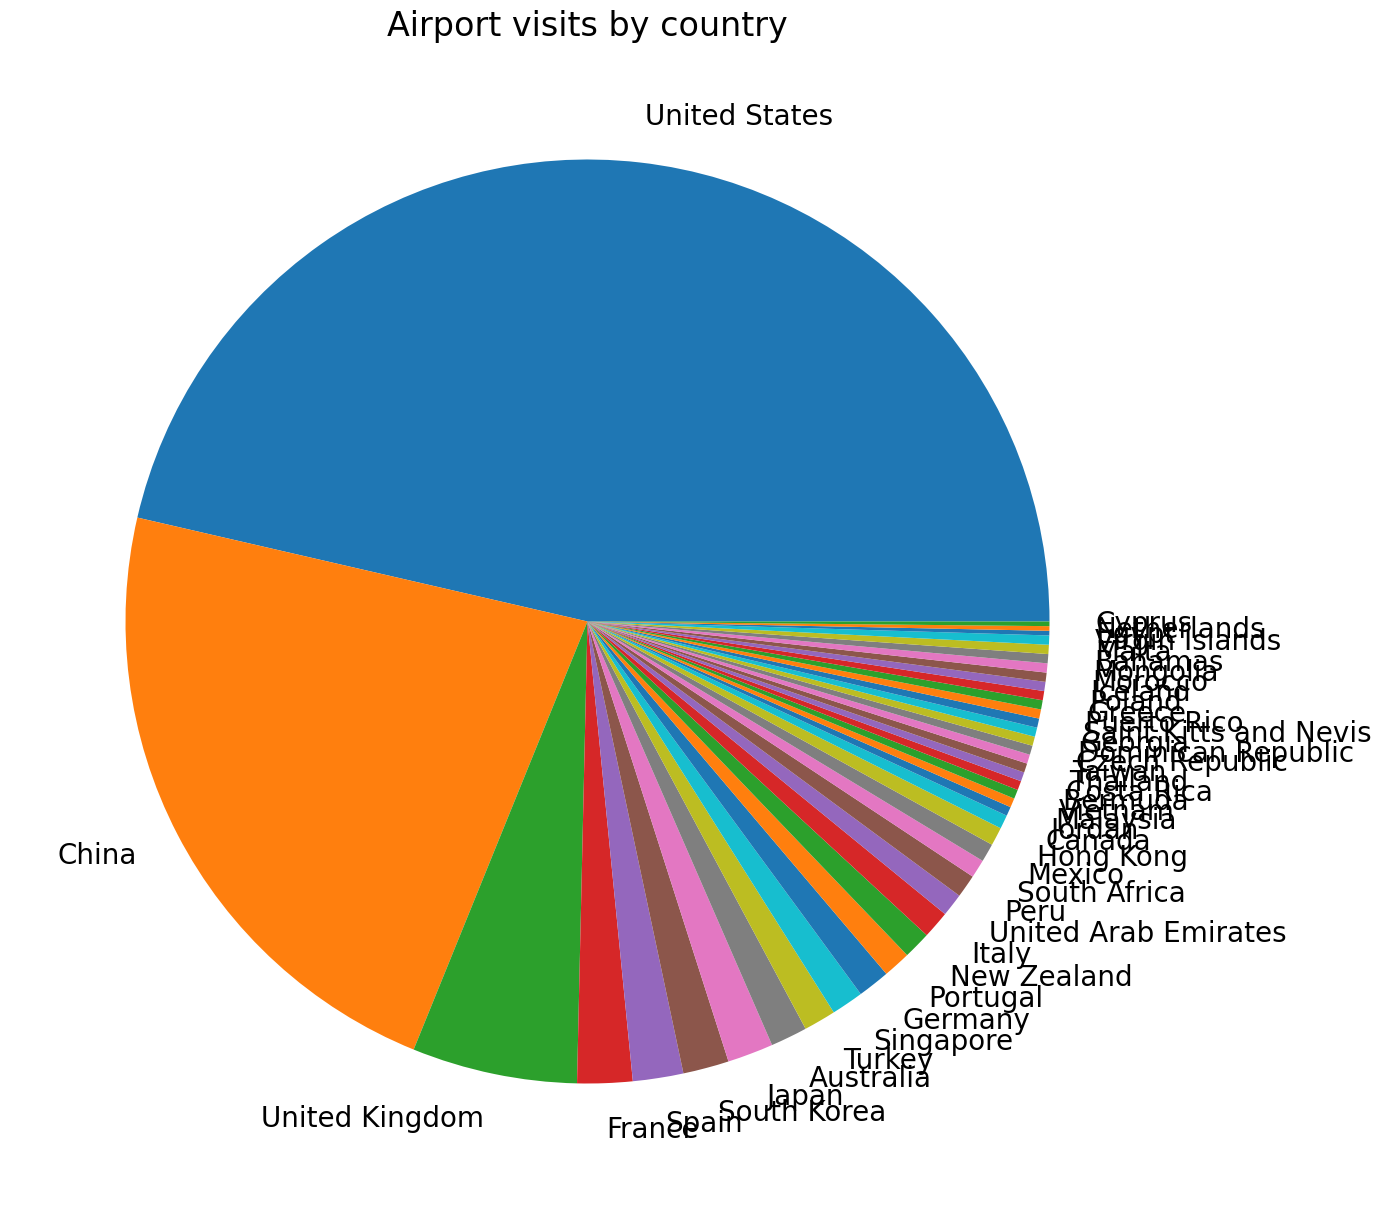

In [102]:
# Countries by visits
fig, ax = plt.subplots(1, 1, figsize=(15,15))
airports_by_country = countries_sorted.reset_index().groupby('Country').agg({'Total Visits': sum, 'Airport': 'count'}).sort_values(by='Total Visits', ascending=False)
airports_by_country.plot('Country', 'Total Visits', kind='pie', legend=False, ax=ax)
ax.set_title('Airport visits by country')
ax.set_ylabel('')
plt.savefig(ROOT_DIR + 'figures/countries.jpg', bbox_inches='tight')

airports_by_country.head(15)

In [103]:
# Airports by destinations
all_airports_aug['dep_dest_hist'] = all_airports_aug['dep_dest_hist'].fillna('')
all_airports_aug['arr_dest_hist'] = all_airports_aug['arr_dest_hist'].fillna('')
all_airports_aug = all_airports_aug.fillna(0)
all_airports_aug['dests'] = all_airports_aug.apply(lambda row: 
                                                       ','.join(sorted(set([t.split(',')[0] for t in (row['dep_dest_hist'] + row['arr_dest_hist']).split(';')]))), 
                                                       axis=1)
all_airports_aug['dests_count'] = all_airports_aug.apply(lambda row: len(row['dests'].split(',')), axis=1)

all_airports_aug['visit_count'] = (all_airports_aug['dep_count'] + all_airports_aug['arr_count'] + all_airports_aug['arr_conn_count']).astype(int)

all_airports_aug[['IATA', 'City', 'Country', 'visit_count', 'dests', 'dests_count']].sort_values(by='dests_count', ascending=False).head(15)


IATA               City         Country  visit_count  \
82   PEK            Beijing           China           75   
98   SFO  San Francisco Bay   United States           70   
33   EWR           New York   United States           42   
14   BOS             Boston   United States           76   
60   LHR             London  United Kingdom           19   
56   LAX        Los Angeles   United States           10   
86   PKX            Beijing           China           10   
44   IAH            Houston   United States            5   
64   LIS             Lisbon        Portugal            6   
108  STN             London  United Kingdom            9   
91   PVG           Shanghai           China            7   
43   IAD         Washington   United States            7   
27   DEN             Denver   United States            7   
80   ORD            Chicago   United States            7   
18   CDG              Paris          France            8   

                                                 dests  dests_count  
82   BOS,CAI,CGQ,CKG,DXB,DYG,EWR,GMP,HGH,HKG,HND,HR...           38  
98   AKL,AUS,BOS,EWR,FRA,HKG,HNL,IAD,IAH,ICN,JFK,KI...           32  
33   BOS,CPT,DTW,FRA,IST,LAX,LHR,LIM,LIS,MEX,NAS,NR...           19  
14   CDG,DEN,DTW,EWR,FRA,IAD,IAH,JFK,KEF,LAX,LHR,LI...           19  
60     AGP,AUH,BOS,BSL,CDG,EWR,FRA,LAX,PEK,SFO,TBS,WAW           12  
56                 BOS,DEN,EWR,IAD,LAS,LHR,ORD,SFO,SYD            9  
86                     AUH,CJU,CSX,HGH,HJJ,PVG,URC,XMN            8  
44                             AUS,BOS,LIM,PUJ,SFO,SJO            6  
64                             EWR,FCO,LGW,MAD,MUC,SFO            6  
108                            MLA,NAP,OZZ,PRG,SAW,VLC            6  
91                             ATH,BOS,CAN,OKA,PEK,PKX            6  
43                             BDL,BOS,LAX,LHR,PHL,SFO            6  
27                             ANC,BDL,BOS,LGA,OGG,SGU            6  
80                             BOS,HNL,LAX,NAS,RDU,SFO            6  
18                                 BOS,HND,LHR,NCE,SEN            5

# STUFF FOR WEB

In [104]:
#### MAKE AIRPORTS AND ROUTES

def make_airport_geojson(df, path):
    airports_aug = augment_airports(df)
    for col in ['dep_first', 'arr_first', 'dep_last', 'arr_last', 'first', 'last']:
        airports_aug[col] = airports_aug[col].dt.strftime('%Y-%m-%d')
    airports_aug = airports_aug.fillna('')
    features = []
    for i, row in airports_aug.iterrows():
#         print(row.drop(['Lat', 'Long']).to_dict())
        features.append(Feature(geometry=Point((row['Long'], row['Lat'])), properties=row.drop(['Lat', 'Long']).to_dict()))
    fc = FeatureCollection(features)
    with open(path, 'w') as f:
        dump(fc, f)
    return airports_aug
        

def get_path(startlong, startlat, endlong, endlat):
    # calculate distance between points
    g = pyproj.Geod(ellps='WGS84')
    (az12, az21, dist) = g.inv(startlong, startlat, endlong, endlat)

    # calculate line string along path with segments <= 1 km
    lonlats = g.npts(startlong, startlat, endlong, endlat,
                     1 + int(dist / 5000))
    
    # npts doesn't include start/end points, so prepend/append them
    lonlats.insert(0, (startlong, startlat))
    lonlats.append((endlong, endlat))
    offset = 0
    for i in range(len(lonlats)-1):
        if lonlats[i][0] > 0 and lonlats[i+1][0] < 0 and lonlats[i+1][0] < -170:
            offset = 360
        elif lonlats[i][0] < 0 and lonlats[i+1][0] > 0 and lonlats[i+1][0] > 170:
            offset = -360
        lonlats[i+1] = (lonlats[i+1][0] + offset , lonlats[i+1][1])
#     print(len(lonlats))
    return LineString(lonlats)


def make_route_geojson(df, path):
    
    grouped = augment_routes(df)
    
    features = []
    for i, row in grouped.iterrows():
    #     lats = row['Sorted Lat'].split(';')
    #     longs = row['Sorted Long'].split(';')
        properties = properties = {'start_iata': row['Dep IATA'], 
                              'start_name': row['Dep Name'], 
                              'start_city_country': row['Dep City'] + ', ' + row['Dep Country'], 
                              'end_iata': row['Arr IATA'], 
                              'end_name': row['Arr Name'], 
                              'end_city_country': row['Arr City'] + ', ' + row['Arr Country'],  
                              'dist': row['Distance'], 
                              'dur': row['Actual Duration (min)'],
                              'domint': row['Domestic/International'],
                              'count': row['count'],
                              'earliest_date': row['route_date_string'].split(';')[0].split(' ')[0],
                              'latest_date': row['route_date_string'].split(';')[-1].split(' ')[0],
                              'date_string': row['route_date_string'],
                              'class_hist': row['route_class_hist'],
                              'airline_hist': row['route_airline_hist'],
                              'flight_string': row['route_flight_string'],
                              'origin_hist': row['route_origin_hist']
                             }
        features.append(Feature(geometry=get_path(row['Dep Long'], row['Dep Lat'], 
                                                  row['Arr Long'], row['Arr Lat']),
                                properties = properties))
    fc = FeatureCollection(features)

    with open(path, 'w') as f:
        dump(fc, f)


make_route_geojson(df, ROOT_DIR + 'routes_all.geojson')
make_airport_geojson(df, ROOT_DIR + 'airports_all.geojson')

all_years = df['Date'].dt.year.unique().tolist()
first_month = min(df[df['Date'].dt.year == all_years[0]]['Date'].dt.month)
last_month = max(df[df['Date'].dt.year == all_years[-1]]['Date'].dt.month)

with open(ROOT_DIR + "month_range.txt", "w") as text_file:
    text_file.write(','.join(str(x) for x in all_years) + '\n' + str(first_month) + ',' + str(last_month))

year_airports_aug = {}
for year in all_years:
    make_route_geojson(df[df['Date'].dt.year == year], ROOT_DIR + 'routes_' + str(year) + '.geojson')
    year_airports_aug[year] = make_airport_geojson(df[df['Date'].dt.year == year], ROOT_DIR + 'airports_' + str(year) + '.geojson')

print('years done')

for year in all_years:
    print(year)
    for month in range(1, 13):
        if year == all_years[0] and month < first_month:
            continue
        if year == all_years[-1] and month > last_month:
            continue
        print('  ', month)
        simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
        make_route_geojson(simp_df, ROOT_DIR + 'routes_cum_' + str(year) + '_' + str(month) + '.geojson')
        make_airport_geojson(simp_df, ROOT_DIR + 'airports_cum_' + str(year) + '_' + str(month) + '.geojson')
    


2024 not in dep


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3959819416.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Class', 'Airline', 'Flight']] = df[['Class', 'Airline', 'Flight']].fillna('Unknown')
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3959819416.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['route_date_string'] = route_grouped['Date'].transform(lambda x: ';'.join(str(a) for a in x))
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/39

2024 not in dep
years done
2015
   1
   2
   3


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series 

   4
   5
   6
   7
   8


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series 

   9
   10
   11
   12
2016
   1
   2
   3
   4
   5


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series 

   6
   7
   8


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9
   10
   11


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   12
2017
   1


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2
   3
   4


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5
   6


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7
   8


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9
   10


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11
   12


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2018
   1
   2


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3
   4


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5
   6


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7
   8


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9
   10


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11
   12


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2019
   1


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2
   3


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5
   6


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11
   12


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2020
   1


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2020 not in dep
   12


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2021
   1


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   12


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2022
   1


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   12


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2023
   1


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   12


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2024
   1


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2024 not in dep
   8


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2024 not in dep
   9


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2024 not in dep
   10


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2024 not in dep
   11


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2024 not in dep
   12


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2024 not in dep
2025
   1


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2024 not in dep
   2


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2024 not in dep
   3


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2024 not in dep
   4


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2024 not in dep
   5


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2024 not in dep
   6


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2024 not in dep
   7


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2024 not in dep
   8


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2024 not in dep
   9


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2024 not in dep
   10


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2024 not in dep
   11


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2024 not in dep
   12


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2024 not in dep
2026
   1


/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/3949066760.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2024 not in dep


# PRINTING

In [105]:
def get_stats(df, airports_aug, year=None, ab=False):
    print(year)
    TOTAL_DIST = df['Distance'].sum()
    TOTAL_TIME = df['Actual Duration (min)'].sum()
    NUM_FLIGHTS = df['Date'].count()
    NUM_AIRLINES = df['Airline'].nunique()
    NUM_COUNTRIES = len(set(df['Dep Country'].tolist()) | set(df['Arr Country'].tolist()))
    NUM_AIRPORTS = len(set(df['Dep Airport'].tolist()) | set(df['Arr Airport'].tolist()))

    dep_countries = df.groupby(['Dep Country', 'Dep Airport']).agg({'Date': 'count'}).reset_index()
    dep_countries.columns = ['Country', 'Airport', 'Departures']
    arr_countries = df.groupby(['Arr Country', 'Arr Airport']).agg({'Date': 'count'}).reset_index()
    arr_countries.columns = ['Country', 'Airport', 'Arrivals']
    countries = pd.merge(dep_countries, arr_countries, how='outer').fillna(0).groupby(['Country', 'Airport']).agg({'Departures': 'first', 'Arrivals': 'first'})
    countries['Total Dep/Arr'] = countries['Departures'] + countries['Arrivals']

    routes_sorted = df.groupby('Sorted Route').agg({'Date': 'count', 'Distance': sum, 'Actual Duration (min)': sum}).sort_values(by='Date', ascending=False)
    routes_sorted.columns = ['Count', 'Total Distance', 'Actual Duration (min)']

    airlines = df.groupby(['Airline']).agg({'Date': 'count', 'Distance': sum, 'Actual Duration (min)': sum}).sort_values(by='Date', ascending=False)
    airlines.columns = ['Count', 'Total Distance', 'Actual Duration (min)']

    dist_year = df.groupby(df['Date'].dt.year).agg({'Distance': sum, 'Date': 'count', 'Actual Duration (min)': sum})
    dist_year.columns = ['Distance', 'Flights', 'Actual Duration (min)']

    dom_int = df.groupby('Domestic/International').agg({'Distance': sum, 'Date': 'count', 'Actual Duration (min)': sum})
    dom_int.columns = ['Distance', 'Flights', 'Actual Duration (min)']

    clas = df.groupby('Class').agg({'Distance': sum, 'Date': 'count', 'Actual Duration (min)': sum})
    clas.columns = ['Distance', 'Flights', 'Actual Duration (min)']
   
    early_arrivals = df[df['Arr Delay (min)'] < 0].shape[0]
    on_time_arrivals = df[(df['Arr Delay (min)'] >= 0) & (df['Arr Delay (min)'] < 15)].shape[0]
    late_arrivals = df[(df['Arr Delay (min)'] >= 15) & (df['Arr Delay (min)'] < 60)].shape[0]
    really_late_arrivals = df[df['Arr Delay (min)'] >= 60].shape[0]

    morning_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 5) & (df['Scheduled Dep Time (Local)'].dt.hour <= 11)].shape[0]
    afternoon_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 12) & (df['Scheduled Dep Time (Local)'].dt.hour <= 17)].shape[0]
    evening_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 18) & (df['Scheduled Dep Time (Local)'].dt.hour <= 22)].shape[0]
    late_night_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 23) | (df['Scheduled Dep Time (Local)'].dt.hour <= 4)].shape[0]

    def get_time(minutes):
        return [int(minutes//60), int(minutes % 60)]

    def get_time_str(minutes):
        if get_time(minutes)[0] == 0:
            return str(get_time(minutes)[1]) + 'min'
        else:
            return str(get_time(minutes)[0]) + 'h ' + str(get_time(minutes)[1]) + 'm'

        
    big_str = ''
    if ab:
        big_str += '<h2><span class=\'bold\'>Alex\'s Flight Log (' + str(first_month) + '/' + str(all_years[0]) + '-' + str(last_month) + '/' + str(all_years[-1]) + ')</span></h2>'
    else:
        big_str += '<h2><span class=\'bold\'>Alex\'s Flight Log (' + str(year) + ')</span></h2>'
        
    big_str += '<p>Total Distance Flown: <span class=\'bold\'>' + '{:,}'.format(TOTAL_DIST).split('.')[0] + '</span>mi' + '\n'
    big_str += '<br>Total Time in Air: <span class=\'bold\'>' + str(timedelta(minutes=int(TOTAL_TIME))) + '</span>' + '\n'
    big_str += '<br>Total Flights: <span class=\'bold\'>' + str(NUM_FLIGHTS) + '</span>' + '\n'
    big_str += '<br>Number of Airlines: <span class=\'bold\'>' + str(NUM_AIRLINES) + '</span>'
    big_str += ', Countries: <span class=\'bold\'>' + str(NUM_COUNTRIES) + '</span>'
    big_str += ', Airports: <span class=\'bold\'>' + str(NUM_AIRPORTS) + '</span>' + '\n'
    big_str += '<p>Longest interval between flights: <span class=\'bold\'>' + str(LONGEST_INTERVAL) + '</span> (' + str(LONGEST_INTERVAL_0) + ' to ' + str(LONGEST_INTERVAL_1) + ')\n'
    big_str += '<br>Month with most flying: <span class=\'bold\'>' 
    big_str += str(a.sort_values('Flights', ascending=False).reset_index().loc[0, 'Y-M']) + '</span> (' 
    big_str += str(int(a.sort_values('Flights', ascending=False).reset_index().loc[0, 'Flights'])) + ' flights, '
    big_str += get_time_str(a.sort_values('Flights', ascending=False).reset_index().loc[0, 'Actual Duration (min)']) + ') or <span class=\'bold\'>'
    big_str += str(a.sort_values('Actual Duration (min)', ascending=False).reset_index().loc[0, 'Y-M']) + '</span> (' 
    big_str += str(int(a.sort_values('Actual Duration (min)', ascending=False).reset_index().loc[0, 'Flights'])) + ' flights, '
    big_str += get_time_str(a.sort_values('Actual Duration (min)', ascending=False).reset_index().loc[0, 'Actual Duration (min)']) + ')\n'


    by_dist = df[df['Actual Duration (min)'] != 0.0].sort_values(by='Actual Duration (min)')
    print(by_dist)
    big_str += ('<p>Shortest flight: <span class=\'bold\'>' + by_dist.iloc[0]['Dep Airport'] + '</span> to <span class=\'bold\'>' + by_dist.iloc[0]['Arr Airport'] + '</span>' 
                + ' (' + '{:,}'.format(by_dist.iloc[0]['Distance']).split('.')[0] + 'mi, ' + get_time_str(by_dist.iloc[0]['Actual Duration (min)']) + ')' + '\n')


    by_dist2 = df.sort_values(by='Actual Duration (min)', ascending=False)
    big_str += ('<br>Longest flight: <span class=\'bold\'>' + by_dist2.iloc[0]['Dep Airport'] + '</span> to <span class=\'bold\'>' + by_dist2.iloc[0]['Arr Airport'] + '</span>' 
                + ' (' + '{:,}'.format(by_dist2.iloc[0]['Distance']).split('.')[0] + 'mi, ' + get_time_str(by_dist2.iloc[0]['Actual Duration (min)']) + ')</p>' + '\n')

    countries_list = countries.reset_index().groupby('Country').count().reset_index()[['Country', 'Airport']].sort_values(by='Airport', ascending=False).values.tolist()
    country_airport = '<p>Airport distribution (top countries): '
    for country, airports in countries_list[:5]:
        country_airport += '<span class=\'bold\'>' + country + '</span>: ' + str(airports) + ', '
    country_airport = country_airport[:-2]
    big_str += country_airport + '\n'

    # visited_airports
    visited_list = airports_aug.sort_values(by='total', ascending=False)[['IATA', 'total']].values.tolist()
    visited_airports = '<br>Airports by total visits: '
    for airport, total in visited_list[:5]:
        visited_airports += '<span class=\'bold\'>' + airport + '</span>: ' + str(int(total)) + ', '
    visited_airports = visited_airports[:-2]
    big_str += visited_airports + '\n'

    routes_list = routes_sorted.reset_index()[['Sorted Route', 'Count']].values.tolist()
    top_routes = '<br>Top routes: '
    for route, count in routes_list[:5]:
        top_routes += '<span class=\'bold\'>' + route.split(' ')[0] + '</span> to <span class=\'bold\'>' + route.split(' ')[1] + '</span>: ' + str(int(count)) + ', '
    top_routes = top_routes[:-2]
    big_str += top_routes + '\n'

    airlines_list = airlines.reset_index()[['Airline', 'Count']].values.tolist()
    top_airlines = '<br>Top airlines: '
    for airline, count in airlines_list[:5]:
        top_airlines += '<span class=\'bold\'>' + airline + '</span>: ' + str(int(count)) + ', '
    top_airlines = top_airlines[:-2]
    big_str += top_airlines + '\n'

    big_str += '<p>Early arrivals: <span class=\'bold\'>' + str(early_arrivals) + '</span> (' + str(round(100*early_arrivals/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>On-time arrivals (within 15min): <span class=\'bold\'>' + str(on_time_arrivals) + '</span> (' + str(round(100*on_time_arrivals/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>Late arrivals (up to 1hr delay): <span class=\'bold\'>' + str(late_arrivals) + '</span> (' + str(round(100*late_arrivals/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>Really late arrivals (>1hr delay): <span class=\'bold\'>' + str(really_late_arrivals) + '</span> (' + str(round(100*really_late_arrivals/NUM_FLIGHTS))+'%)\n'
    big_str += '</p>\n'
    
    big_str += '<p>Morning flights (5am-12p): <span class=\'bold\'>' + str(morning_flights) + '</span> (' + str(round(100*morning_flights/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>Afternoon flights (12p-6p): <span class=\'bold\'>' + str(afternoon_flights) + '</span> (' + str(round(100*afternoon_flights/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>Evening flights (6p-11p): <span class=\'bold\'>' + str(evening_flights) + '</span> (' + str(round(100*evening_flights/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>Late night flights (11p-5a): <span class=\'bold\'>' + str(late_night_flights) + '</span> (' + str(round(100*late_night_flights/NUM_FLIGHTS))+'%)\n'
    big_str += '</p>\n'
    
    dom_int_list = dom_int.reset_index()[['Domestic/International', 'Distance', 'Flights']].values.tolist()
    domint = '<p>'
    for di, dist, count in dom_int_list:
        domint += '<span class=\'bold\'>' + di + '</span>: ' + '{:,}'.format(dist).split('.')[0] + 'mi, ' + str(int(count)) + ' flights\n<br>'
    domint = domint[:-5] + '</p>'
    big_str += domint + '\n'

    class_list = clas.reset_index()[['Class', 'Distance', 'Flights']].values.tolist()
    class_str = '<p>'
    for c, dist, count in class_list:
        class_str += '<span class=\'bold\'>' + c + '</span>: ' + '{:,}'.format(dist).split('.')[0] + 'mi, ' + str(int(count)) + ' flights\n<br>'
    class_str = class_str[:-5] + '</p>'
    big_str += class_str + '\n'
    
    if ab: # ind years don't need this
        print(dist_year.reset_index())
        years_list = dist_year.reset_index()[['Date', 'Distance', 'Flights', 'Actual Duration (min)']].values.tolist()
        years = '<p>'
        for year, dist, count, dur in years_list:
            years += '<span class=\'bold\'>' + str(int(year)) + '</span>: ' + get_time_str(dur) + ', ' + str(int(count)) + ' flights, ' + '{:,}'.format(dist).split('.')[0] + 'mi \n<br>'
        years = years[:-5] + '</p>'
        big_str += years + '\n'

#     print(big_str)
    return big_str

big_str = get_stats(df, all_airports_aug, ab=True)
with open(ROOT_DIR + "all_stats.txt", "w") as text_file:
    text_file.write(big_str)
for i, year in enumerate(all_years):
    big_str = get_stats(df[df['Date'].dt.year == year], year_airports_aug[year], year=year)
    with open(ROOT_DIR + str(year) + "_stats.txt", "w") as text_file:
        text_file.write(big_str)

None
          Date Scheduled Dep Time (Local) Scheduled Arr Time (Local)  \
303 2024-07-01        2024-07-01 14:35:00        2024-07-01 15:18:00   
65  2017-11-13        2017-11-13 06:00:00        2017-11-13 07:03:00   
194 2022-01-03        2022-01-03 18:10:00        2022-01-03 19:10:00   
58  2017-09-22        2017-09-22 08:30:00        2017-09-22 09:32:00   
142 2020-05-20        2020-05-20 18:30:00        2020-05-20 19:48:00   
59  2017-09-24        2017-09-24 17:05:00        2017-09-24 18:25:00   
38  2017-03-20        2017-03-20 21:52:00        2017-03-20 23:05:00   
111 2019-07-08        2019-07-08 08:00:00        2019-07-08 09:18:00   
244 2023-04-22        2023-04-22 08:15:00        2023-04-22 09:30:00   
27  2016-12-15        2016-12-15 09:15:00        2016-12-15 10:35:00   
66  2017-11-13        2017-11-13 09:00:00        2017-11-13 10:24:00   
118 2019-09-28        2019-09-28 20:30:00        2019-09-28 21:47:00   
4   2015-03-19        2015-03-19 20:32:00        2015-03-19

/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/2360708355.py:17: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  routes_sorted = df.groupby('Sorted Route').agg({'Date': 'count', 'Distance': sum, 'Actual Duration (min)': sum}).sort_values(by='Date', ascending=False)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/2360708355.py:20: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  airlines = df.groupby(['Airline']).agg({'Date': 'count', 'Distance': sum, 'Actual Duration (min)': sum}).sort_values(by='Date', ascending=False)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/23607

          Date Scheduled Dep Time (Local) Scheduled Arr Time (Local)  \
194 2022-01-03        2022-01-03 18:10:00        2022-01-03 19:10:00   
204 2022-04-12        2022-04-12 16:13:00        2022-04-12 17:51:00   
224 2022-12-18        2022-12-18 09:00:00        2022-12-18 10:25:00   
213 2022-10-10        2022-10-10 09:10:00        2022-10-10 10:36:00   
212 2022-10-07        2022-10-07 20:25:00        2022-10-07 21:48:00   
205 2022-04-13        2022-04-13 10:14:00        2022-04-13 11:57:00   
202 2022-04-01        2022-04-01 16:48:00        2022-04-01 19:48:00   
225 2022-12-24        2022-12-24 19:10:00        2022-12-24 20:55:00   
220 2022-11-27        2022-11-27 21:10:00        2022-11-28 00:10:00   
219 2022-11-25        2022-11-25 13:05:00        2022-11-25 13:55:00   
203 2022-04-05        2022-04-05 07:31:00        2022-04-05 08:50:00   
216 2022-10-19        2022-10-19 06:15:00        2022-10-19 10:15:00   
215 2022-10-14        2022-10-14 19:30:00        2022-10-14 21:4

/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/2360708355.py:17: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  routes_sorted = df.groupby('Sorted Route').agg({'Date': 'count', 'Distance': sum, 'Actual Duration (min)': sum}).sort_values(by='Date', ascending=False)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/2360708355.py:20: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  airlines = df.groupby(['Airline']).agg({'Date': 'count', 'Distance': sum, 'Actual Duration (min)': sum}).sort_values(by='Date', ascending=False)
/var/folders/gq/4z9x23w55k530vrnxr1wb2b00000gn/T/ipykernel_13497/23607

In [106]:
# Checking code

##### Code to check duration ######

# Convert durations to datetime object. DELETE AFTER CLEAN
# for col in ['Scheduled Difference', 'Actual Difference']:
#     df[col] = df[col].fillna('00:00')
#     df[col] = df[col].apply(lambda x: f'{x}:00')
#     df[col] = pd.to_timedelta(df[col])

# # Delete section after clean
# non_matching_scheduled = df[df['Scheduled Duration'] != df['Scheduled Difference']]
# non_matching_actual = df[df['Actual Duration'] != df['Actual Difference']]
# if (not non_matching_scheduled.empty):
#     print(non_matching_scheduled[['Date', 'Flight', 'Scheduled Duration', 'Scheduled Difference']])
# if (not non_matching_actual.empty):
#     print(non_matching_actual[['Date', 'Flight', 'Actual Duration', 'Actual Difference']])

####################################